<a href="https://colab.research.google.com/github/kohathyli/Autoencoders_Census/blob/main/measure_accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Autoencoders and Data Quality for Tabular Data**

In [15]:
!rm -rf autoencoders_census
!git clone https://github.com/ipeirotis/autoencoders_census.git
%cd autoencoders_census

Cloning into 'autoencoders_census'...
remote: Enumerating objects: 531, done.
remote: Counting objects: 100% (165/165), done.
remote: Compressing objects: 100% (163/163), done.
remote: Total 531 (delta 101), reused 2 (delta 2), pack-reused 366
Receiving objects: 100% (531/531), 52.42 MiB | 14.01 MiB/s, done.
Resolving deltas: 100% (315/315), done.
/content/autoencoders_census/autoencoders_census


In [16]:
from google.colab import auth

# Login using the account that has access to the Google project
# in order to access the resources for the project
auth.authenticate_user()

In [17]:
# This code imports the DataTransformer object from
# the notebook pandas2vector.ipynb
!pip install -q import_ipynb keras-tuner
import import_ipynb
from pandas2vector import Table2Vector
from data_loader import DataLoader
from autoencoder import AutoencoderModel
from autoencoder import VariationalAutoencoderModel

# Data Source

The used data stems from the Youth Risk Behavior Surveillance System by CDC (Centers for Disease Control and Prevention). It includes data on a set of surveys that track behaviors that can lead to poor health in students grades 9 through 12. [Here](https://www.cdc.gov/healthyyouth/data/yrbs/data.htm) is the link to the dataset.

Note: The dataset is updated every two years. We use the 2017 version of the national high school YRBS dataset.

## Libraries

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, label_binarize
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix
from pandas.api.types import is_numeric_dtype
from matplotlib.offsetbox import TransformedBbox

In [20]:
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.interpolate import interp1d
from numpy.random import uniform
from numpy.random import seed

In [21]:
from keras.layers import Input, Lambda
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras import backend as K
from keras import Model

In [22]:
import tensorflow as tf
from tensorflow.random import set_seed
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow import keras

# Load Original Dataset

In [23]:

# Data Source
data_loader = DataLoader()

project_data, variable_types  = data_loader.load_2017()



In [24]:
project_data.shape

(14765, 98)

In [25]:
project_data.dropna().shape

(14765, 98)

# Vectorizing the data set

In [26]:
# Data Transformation
vectorizer = Table2Vector(variable_types)


# Without indicator variables for missingness
vectorized_df = vectorizer.vectorize_table(project_data)

In [27]:
assert( vectorizer.tabularize_vector(vectorized_df).shape == project_data.shape )

# Autoencoder loading

In [14]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import custom_object_scope
import gcsfs




# Define the path to the file on GCS
gcs_model_path = "gs://autoencoder_census_models/best_parameters_autoencoder.keras"

# Define the local path where the model will be downloaded
local_model_path = "best_parameters_autoencoder.keras"

# Create a GCS filesystem object using your project ID
fs = gcsfs.GCSFileSystem(project='autoencoder-census')

# Download the model file from GCS
with fs.open(gcs_model_path, 'rb') as gcs_file:
    with open(local_model_path, 'wb') as local_file:
        local_file.write(gcs_file.read())


# Initialize AutoencoderModel with attribute_cardinalities
# to use the custom loss function
attr_cardinalities = list(project_data.describe().T['unique'].values)
autoencoder_model = AutoencoderModel(attr_cardinalities)


# Load the model from the local file
model = load_model(local_model_path)




ValueError: ignored

## Making Predictions and Filling in the Missing Values


In [ ]:

filled = vectorized_df.fillna(vectorized_df.median())

# Define a condition for stopping the iteration
epsilon = 1e-5
old_filled = None

while old_filled is None or np.abs(filled - old_filled).sum().sum() > epsilon:
  # Save the old filled DataFrame for convergence check
  old_filled = filled.copy()

  # Run the data through the autoencoder, which will return a complete version of the data.
  predicted = model.predict(filled)

  # Replace the initially guessed values in the original data with the corresponding values from the autoencoder's output. But keep the observed values unchanged.
  mask = vectorized_df.isna()
  filled[mask] = np.where(mask, predicted, filled)


In [ ]:
filled

Now that we have filled in the original dataset with the most likely values for their missing values, we run the Autoencoder on the filled vectorized dataset.

In [ ]:
predicted = pd.DataFrame(model.predict(filled))
predicted.columns = filled.columns
predicted

In [ ]:
tabular_from_predicted = vectorizer.tabularize_vector(predicted)

## Visualization of the original vs reconstructed

In [ ]:

def create_scatterplot_for_numeric(original_df, predicted_df, numeric_attr):
  plt.figure(figsize=(10, 6))  # Create a new figure with a particular size
  plt.scatter(original_df[numeric_attr], predicted_df[numeric_attr], s=1)  # Create a scatterplot
  plt.xlabel(f'Original Data ({numeric_attr})')  # Set the x-axis label
  plt.ylabel(f'Reconstructed Data ({numeric_attr})')  # Set the y-axis label
  plt.title(f'Scatterplot for {numeric_attr}')  # Set the plot title
  plt.show()  # Display the plot

for v in variable_types.keys():
  if variable_types[v] == 'numeric':
    print(v)
    create_scatterplot_for_numeric(project_data, tabular_from_predicted, v)



In [ ]:

def create_scatterplot_for_categorical(original_df, predicted_df, categ_attr):
    # Create a list of all unique categories present in the original data
    all_categories = original_df[categ_attr].unique()

    # Create the confusion matrix using crosstab
    confusion_matrix = pd.crosstab(original_df[categ_attr], predicted_df[categ_attr])

    # Reindex the confusion matrix to include all categories in the original data
    confusion_matrix = confusion_matrix.reindex(index=all_categories, columns=all_categories, fill_value=0)

    # Calculate accuracy
    diagonal_sum = np.trace(confusion_matrix.values)
    total_sum = np.sum(confusion_matrix.values)
    accuracy = diagonal_sum / total_sum * 100

    # Calculate baseline accuracy
    baseline_accuracy = original_df[categ_attr].value_counts().max() / total_sum * 100


    plt.figure(figsize=(5, 5))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap="YlGnBu")
    plt.title(f"Accuracy: {accuracy:.2f}%, Baseline accuracy: {baseline_accuracy:.2f}%")
    plt.show()
    return accuracy, baseline_accuracy

result = []
for v in variable_types.keys():
  if variable_types[v] == 'categorical':
    print(v)
    a,b = create_scatterplot_for_categorical(project_data, tabular_from_predicted, v)
    entry = { 'variable': v, 'accuracy': a, 'baseline_accuracy': b }
    result.append(entry)

result = pd.DataFrame(result)




In [ ]:
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.preprocessing import label_binarize

def calculate_extended_metrics(original_df, predicted_df, categ_attr):
    all_categories = original_df[categ_attr].unique()
    confusion_matrix = pd.crosstab(original_df[categ_attr], predicted_df[categ_attr])
    confusion_matrix = confusion_matrix.reindex(index=all_categories, columns=all_categories, fill_value=0)

    diagonal_sum = np.trace(confusion_matrix.values)
    total_sum = np.sum(confusion_matrix.values)

    accuracy = diagonal_sum / total_sum * 100
    baseline_accuracy = original_df[categ_attr].value_counts().max() / total_sum * 100

    # One-vs-All ROC and AUC
    y_true = label_binarize(original_df[categ_attr], classes=all_categories)
    y_pred = label_binarize(predicted_df[categ_attr], classes=all_categories)
    ova_roc_auc = roc_auc_score(y_true, y_pred, multi_class='ovr', average='macro')

    return accuracy, baseline_accuracy, ova_roc_auc

# Example usage:
# accuracy, baseline_accuracy, ova_roc_auc = calculate_extended_metrics_without_prob(original_df, predicted_df, categ_attr)


result = []
for v in variable_types.keys():
  if variable_types[v] == 'categorical':
    print(v)
    if v.endswith("_cat"): continue # do not analyze numeric vars for now
    a,b, c = calculate_extended_metrics(project_data, tabular_from_predicted, v)
    entry = { 'variable': v, 'accuracy': round(a,1), 'baseline_accuracy': round(b,1), 'ova_auc': c, 'lift': round(a/b,2) }
    result.append(entry)

df = pd.DataFrame(result)

df['lift'].mean()



In [ ]:
df.sort_values(by='ova_auc', ascending=False).head(25)

In [ ]:
df.sort_values(by=['ova_auc','baseline_accuracy'], ascending=True).head(25)

In [ ]:
df.plot(x='baseline_accuracy', y='ova_auc', kind='scatter')
plt.show()

Variational Autoencoder Loading

In [28]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import custom_object_scope
import gcsfs




# Define the path to the file on GCS
gcs_model_path = "gs://autoencoder_census_models/best_parameters_variationalautoencoder.keras"

# Define the local path where the model will be downloaded
local_model_path = "best_parameters_variationalautoencoder.keras"

# Create a GCS filesystem object using your project ID
fs = gcsfs.GCSFileSystem(project='autoencoder-census')

# Download the model file from GCS
with fs.open(gcs_model_path, 'rb') as gcs_file:
    with open(local_model_path, 'wb') as local_file:
        local_file.write(gcs_file.read())


# Initialize AutoencoderModel with attribute_cardinalities
# to use the custom loss function
attr_cardinalities = list(project_data.describe().T['unique'].values)
variational_autoencoder_model = VariationalAutoencoderModel(attr_cardinalities)


# Load the model from the local file
model = load_model(local_model_path, safe_mode = False)

Make Predictions and Fill in the Missing Value

In [29]:
filled = vectorized_df.fillna(vectorized_df.median())

epsilon = 1e-5
old_filled = None

while old_filled is None or np.abs(filled - old_filled).sum().sum() > epsilon:
  old_filled = filled.copy()
  predicted = model.predict(filled)
  mask = vectorized_df.isna()
  filled[mask] = np.where(mask, predicted, filled)

462/462 [==============================] - 8s 6ms/step


In [30]:
predicted = pd.DataFrame(model.predict(filled))
predicted.columns = filled.columns

462/462 [==============================] - 4s 9ms/step


In [31]:
tabular_from_predicted = vectorizer.tabularize_vector(predicted)

Visualization of the original vs. the reconstructed

In [32]:
def create_scatterplot_for_numeric(original_df, predicted_df, numeric_attr):
  plt.figure(figsize=(10, 6))
  plt.scatter(original_df[numeric_attr], predicted_df[numeric_attr], s=1)
  plt.xlabel(f'Original Data ({numeric_attr})')
  plt.ylabel(f'Reconstructed Data ({numeric_attr})')
  plt.title(f'Scatterplot for {numeric_attr}')
  plt.show()

for v in variable_types.keys():
  if variable_types[v] == 'numeric':
    print(v)
    create_scatterplot_for_numeric(project_data, tabular_from_predicted, v)

age


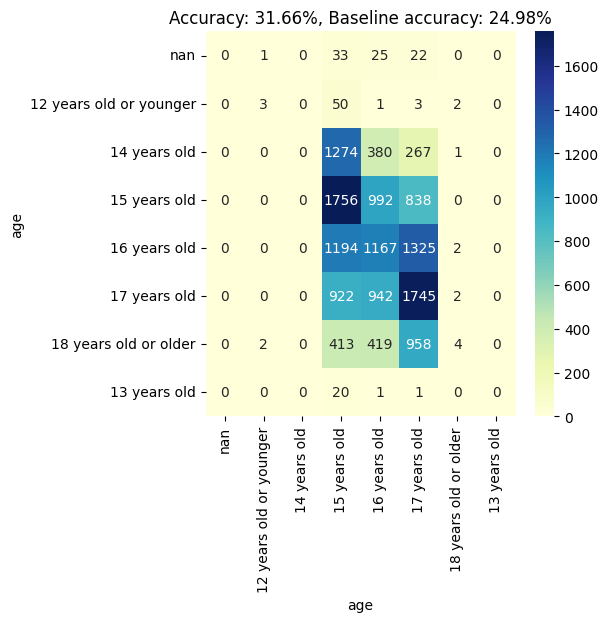

sex


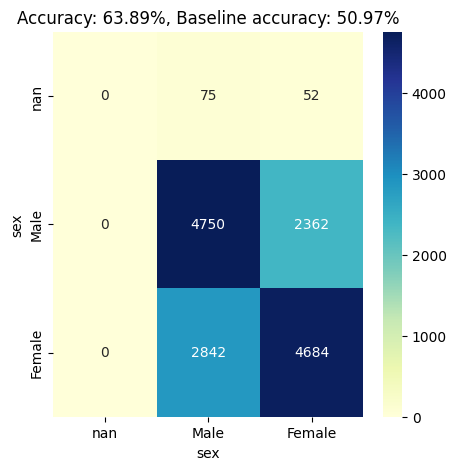

grade


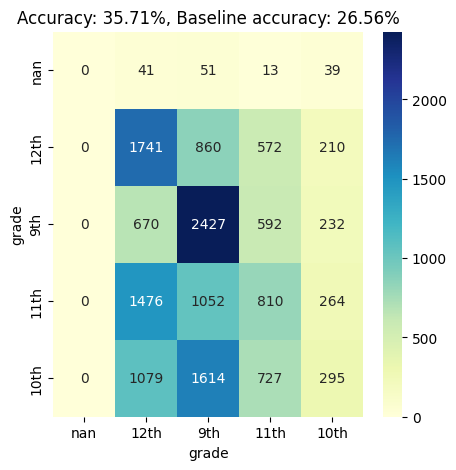

Hispanic_or_Latino


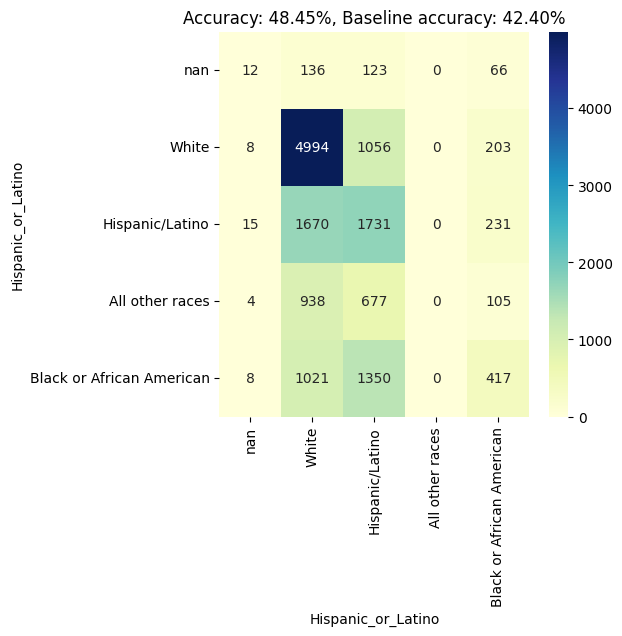

race


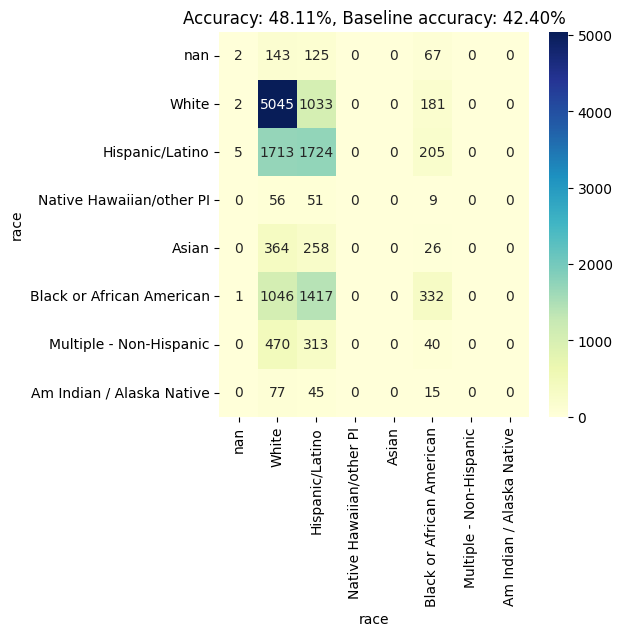

obese


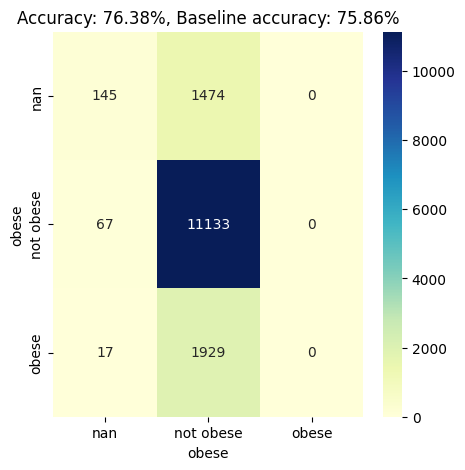

overweight


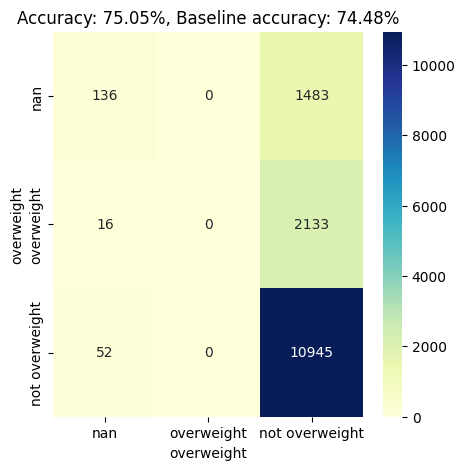

sexual_identity


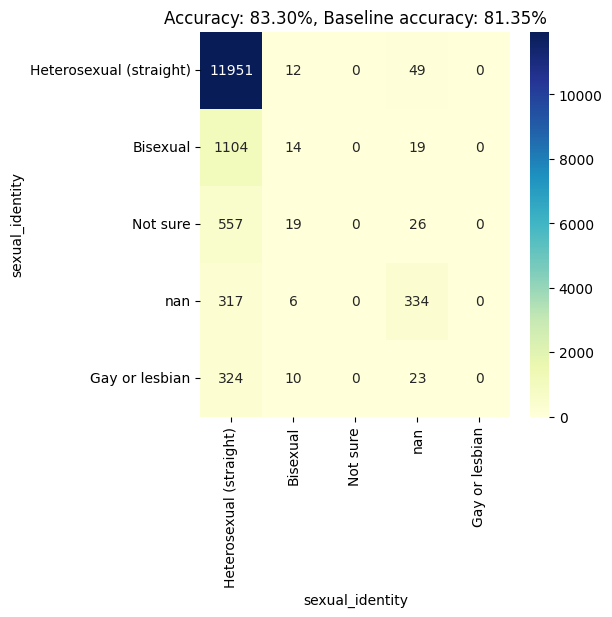

sex/sexual_contacts


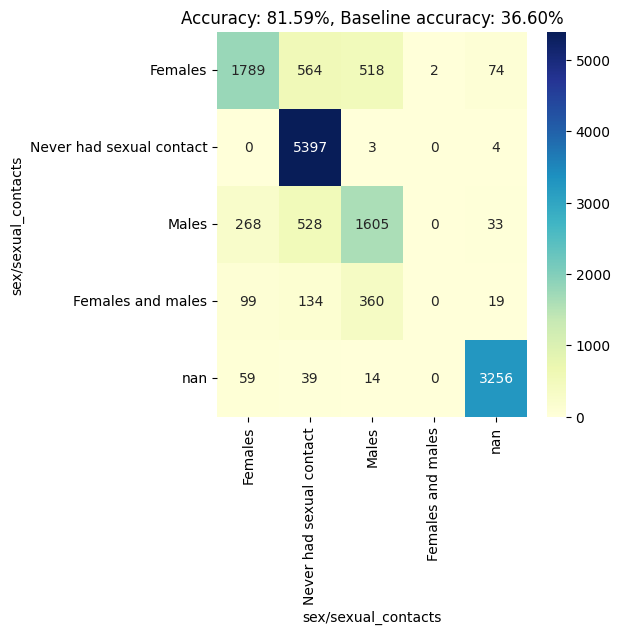

sexid


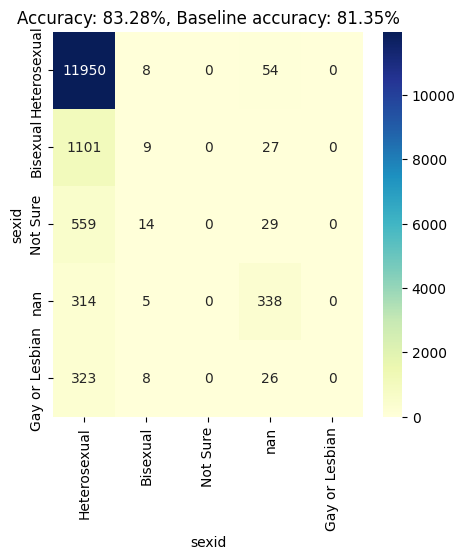

sexid2


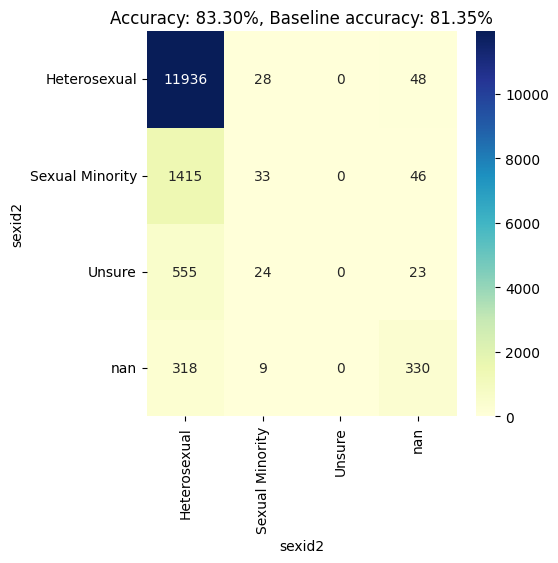

sexpart


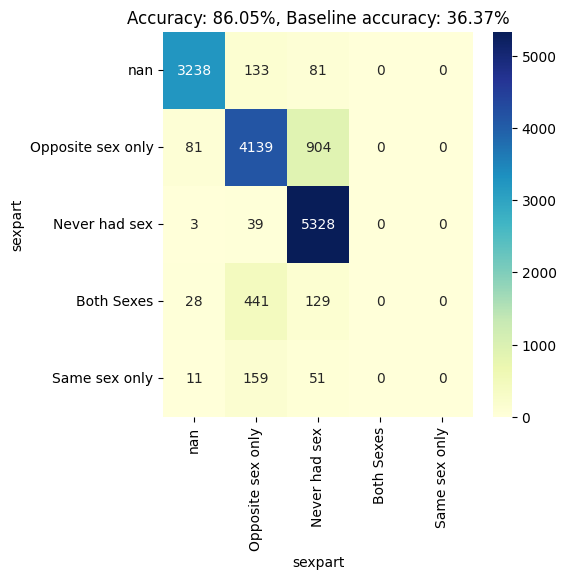

sexpart2


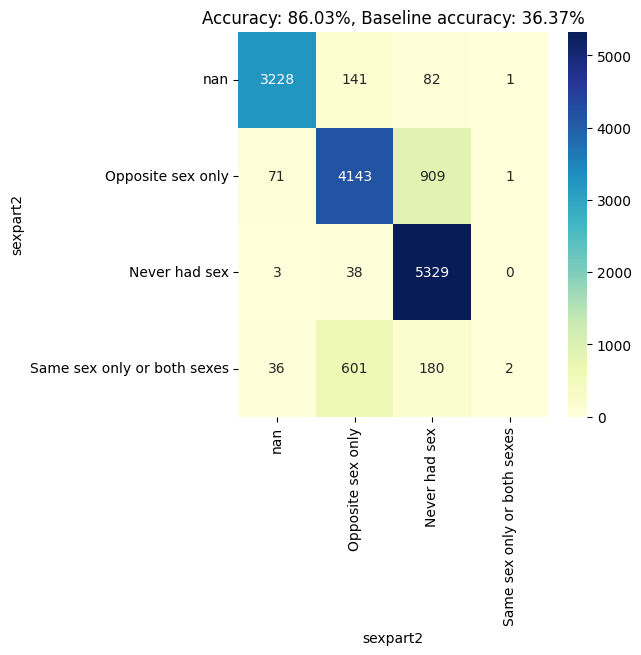

seat_belt_use


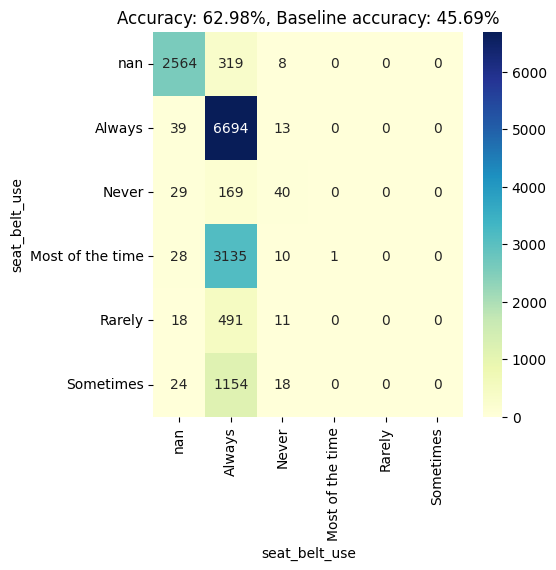

riding_with_a_drinking_driver


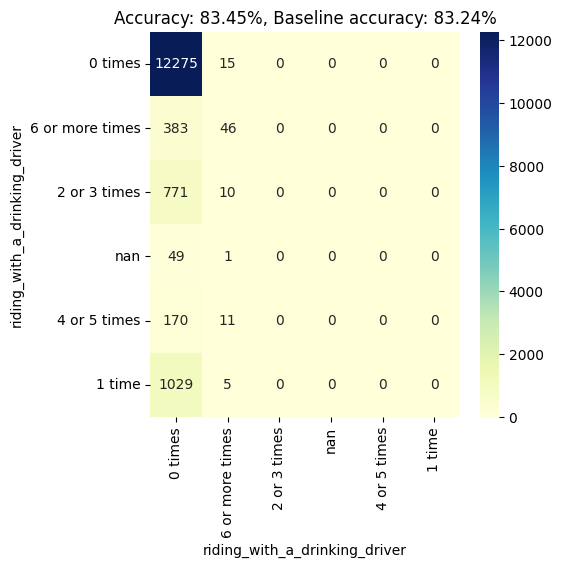

drinking_and_driving


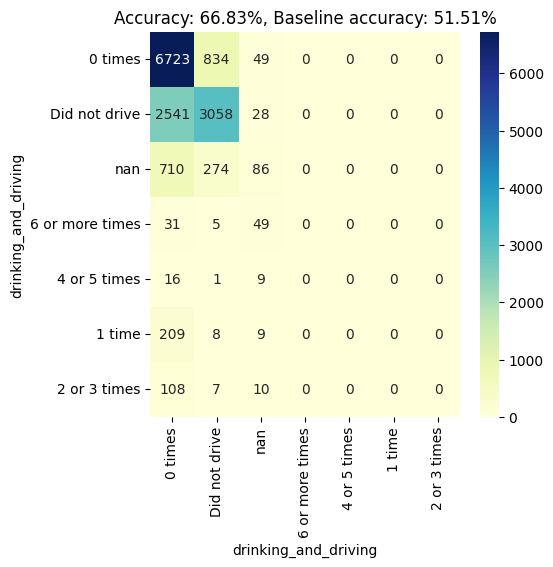

texting_and_driving


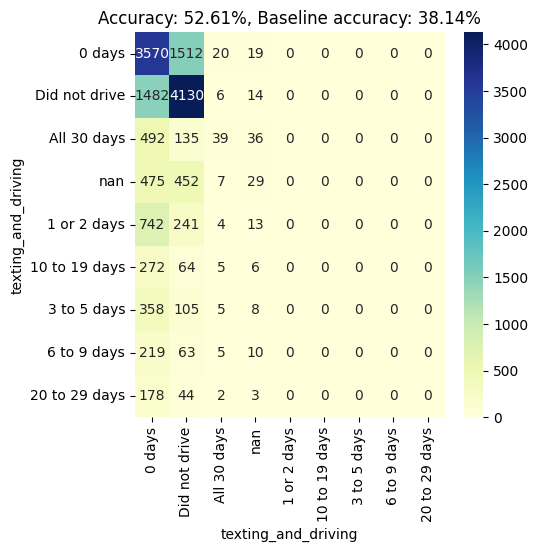

weapon_carrying


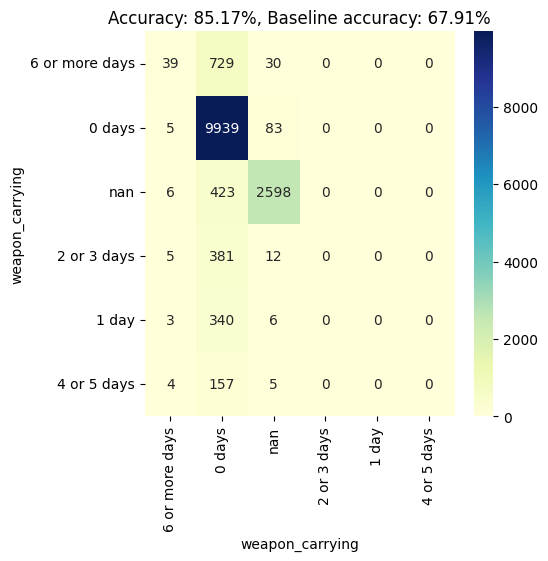

weapon_carrying_at_school


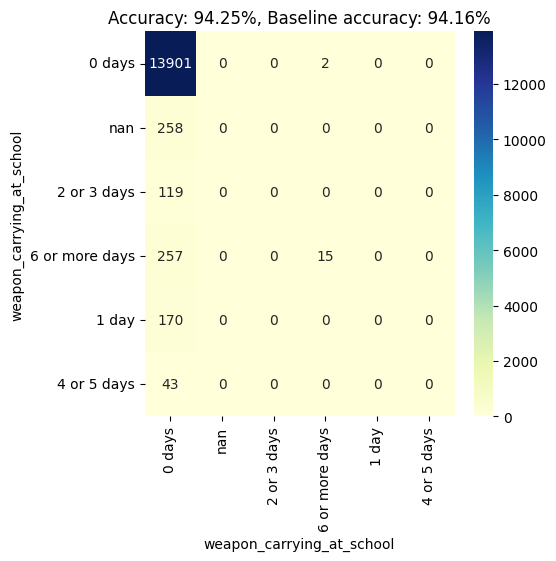

safety_concerns_at_school


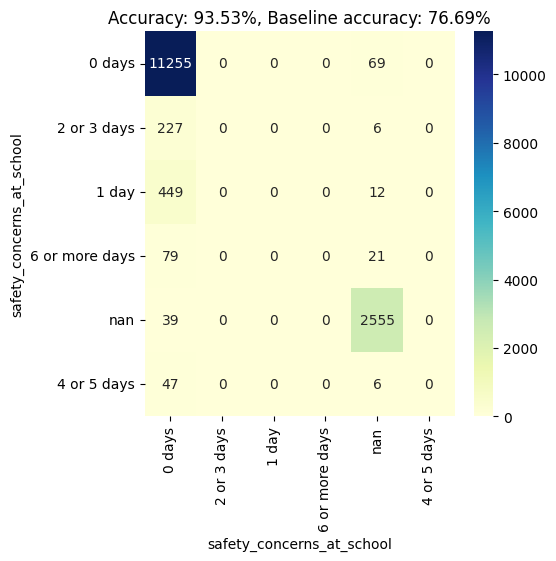

threatened_at_school


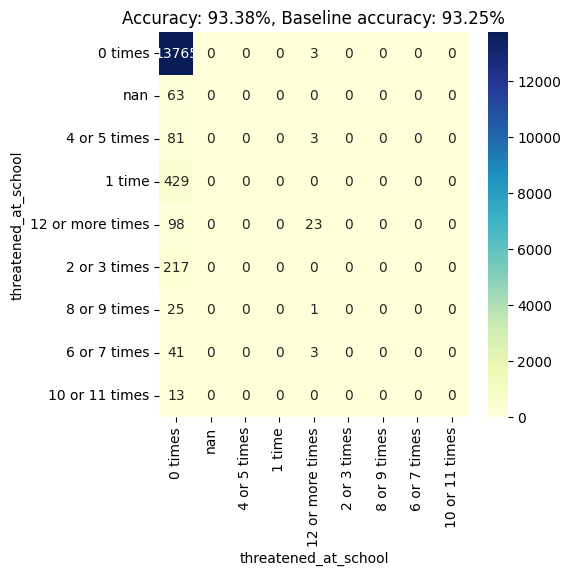

physical_fighting


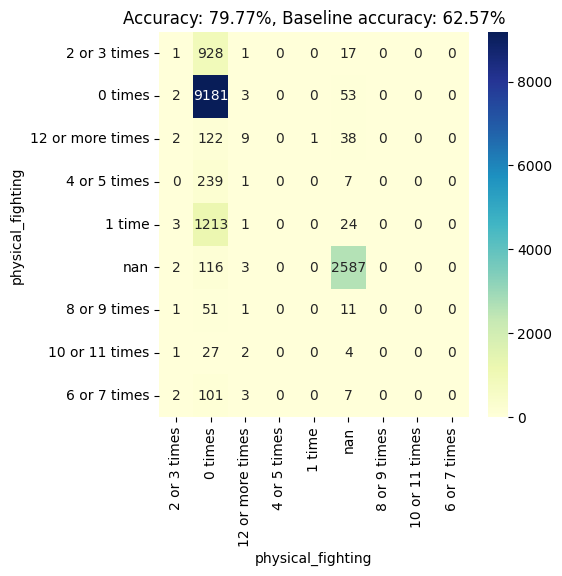

physical_fighting_at_school


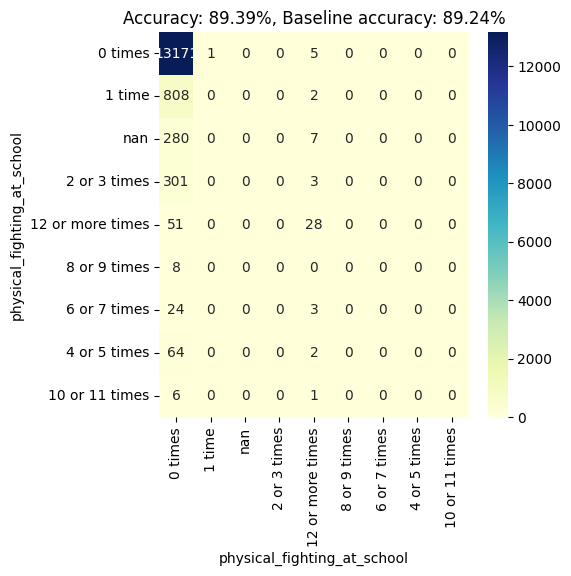

forced_sexual_intercourse


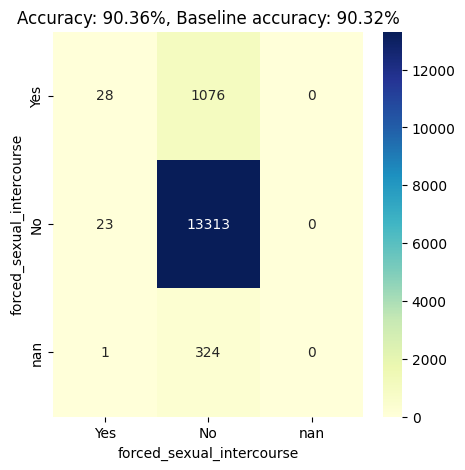

sexual_dating_violence


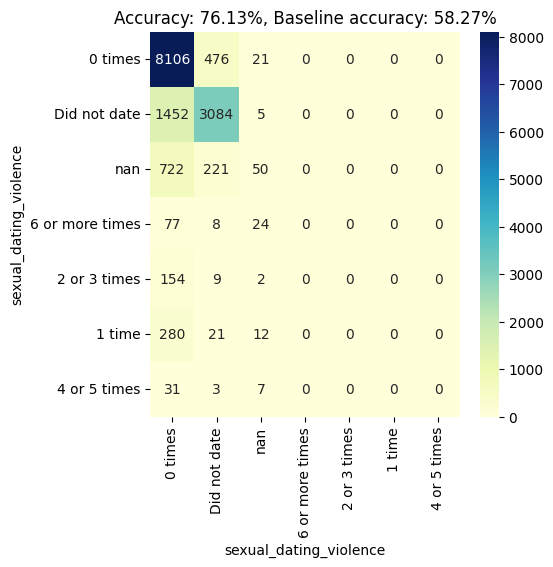

physical_dating_violence


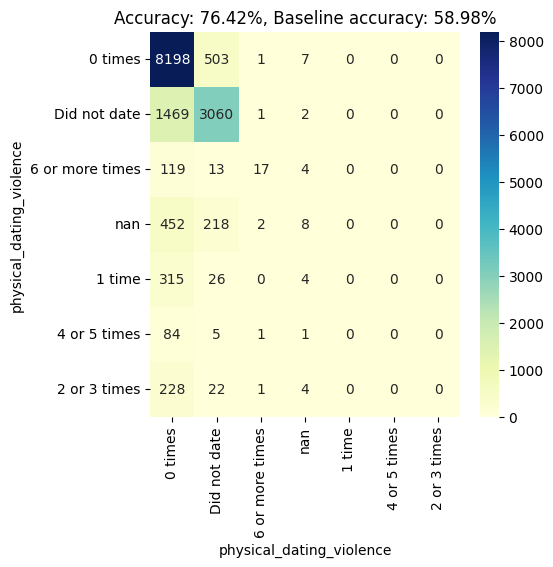

bullying_at_school


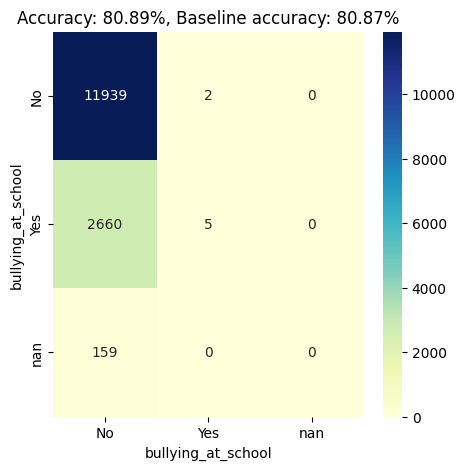

electronic_bullying


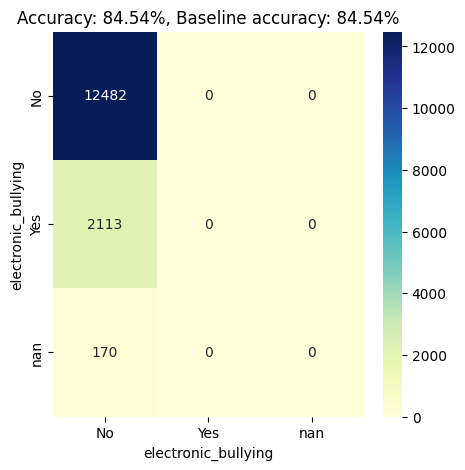

sad_or_hopeless


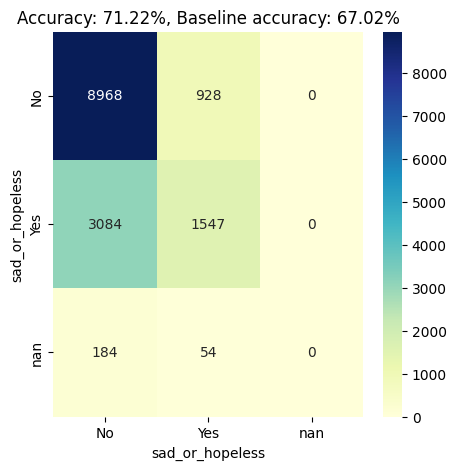

considered_suicide


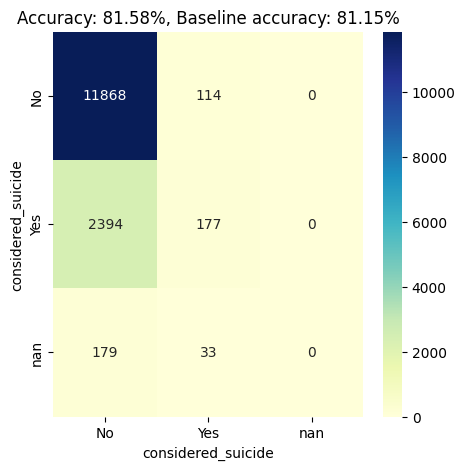

made_a_suicide_plan


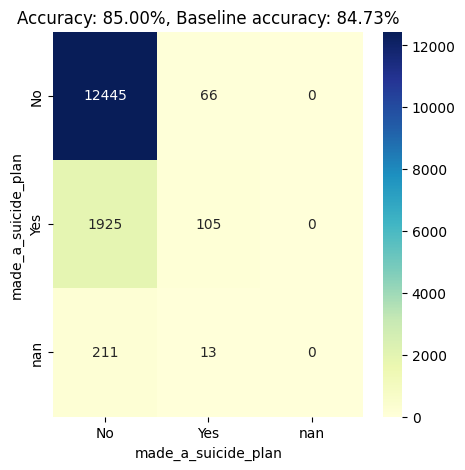

attempted_suicide


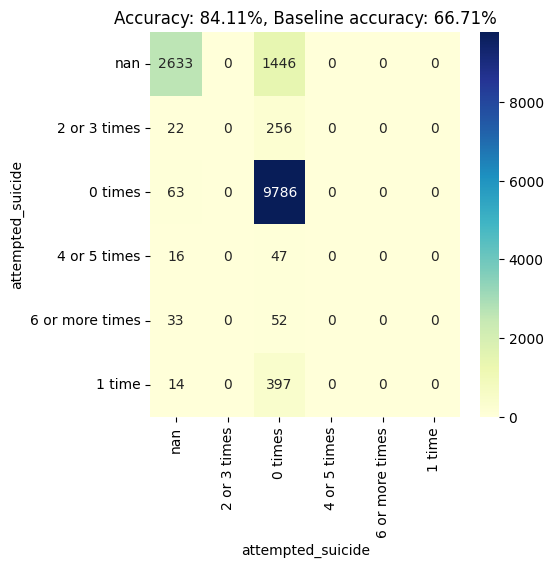

injurious_suicide_attempt


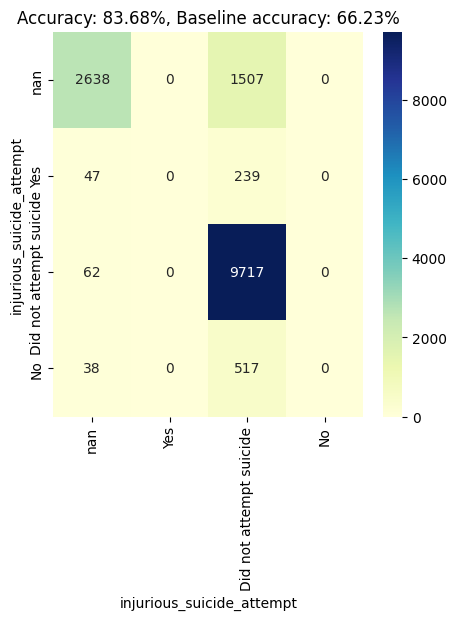

ever_cigarette_use


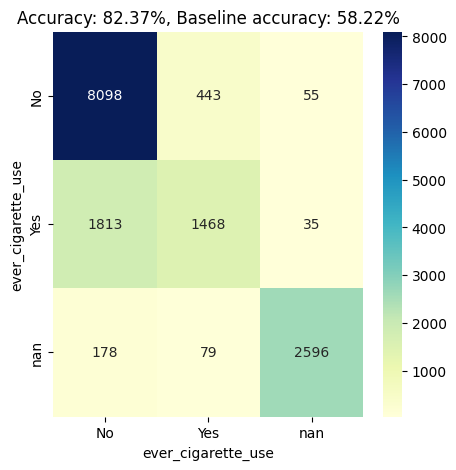

current_cigarette_use


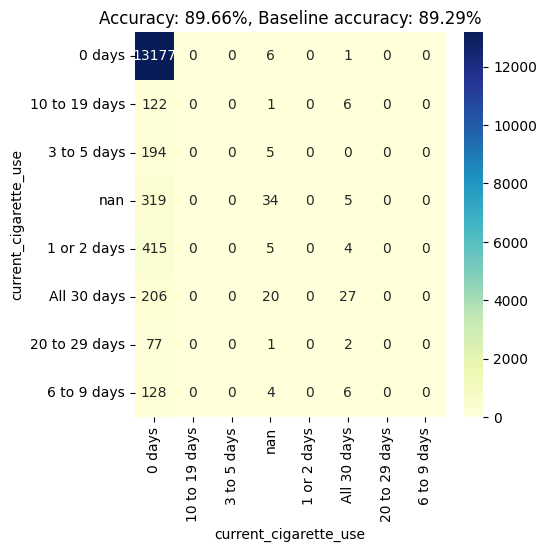

smoking_amounts_per_day


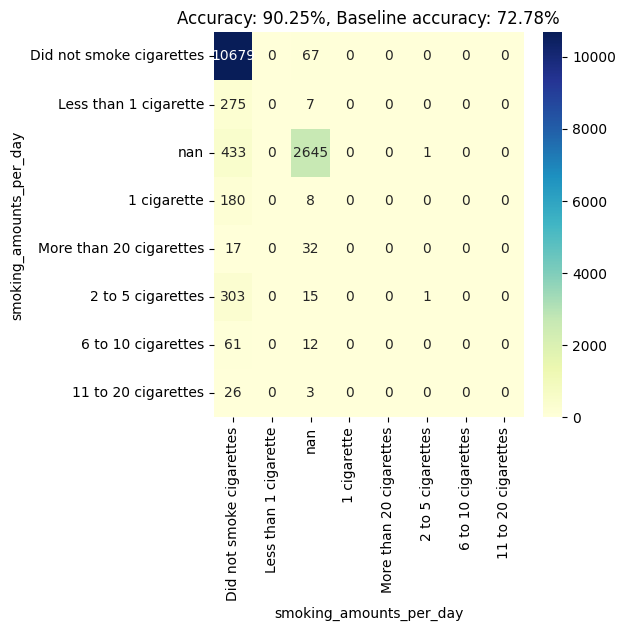

electronic_vapor_product_use


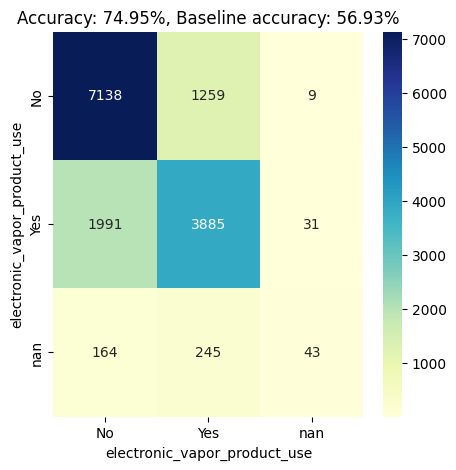

current_electronic_vapor_product_use


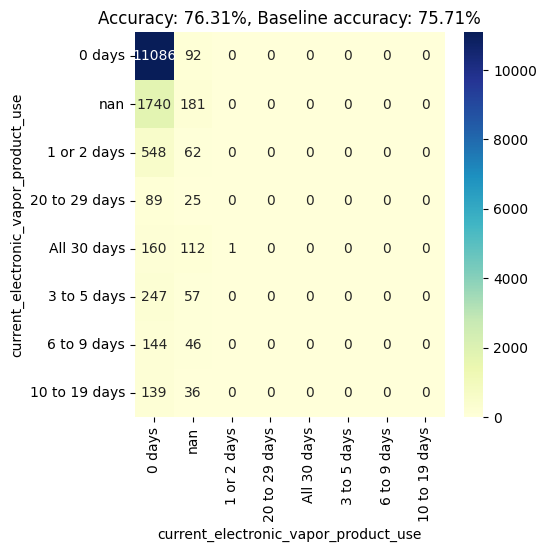

current_cigar_use


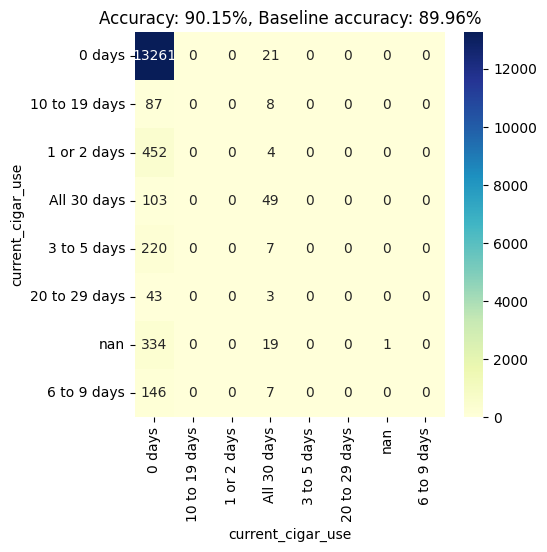

ever_alcohol_use


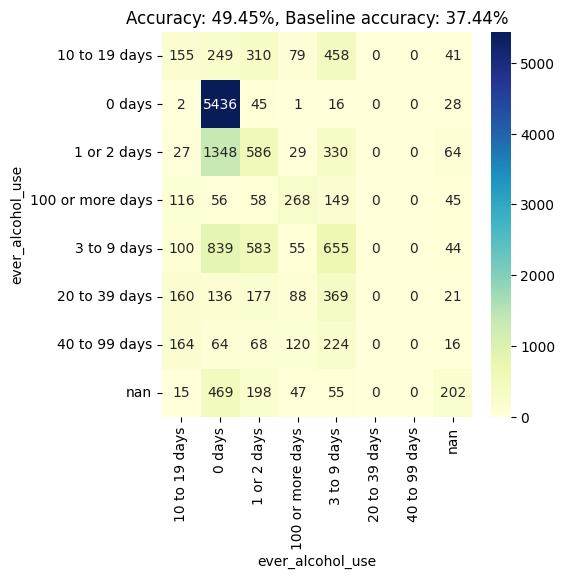

initiation_of_alcohol_use


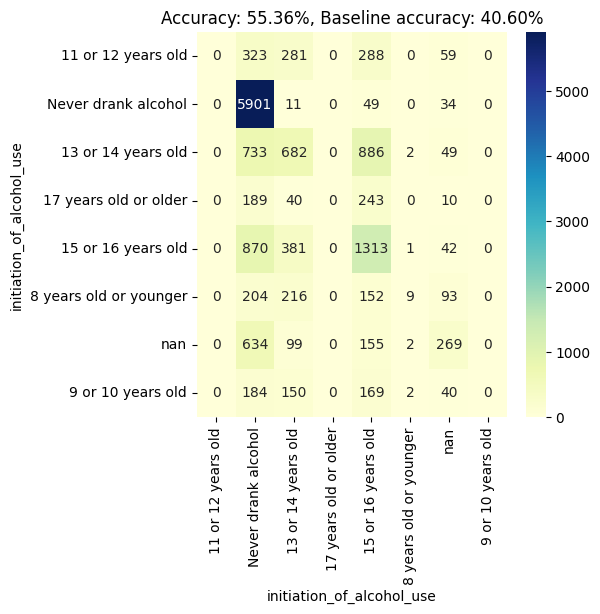

current_alcohol_use


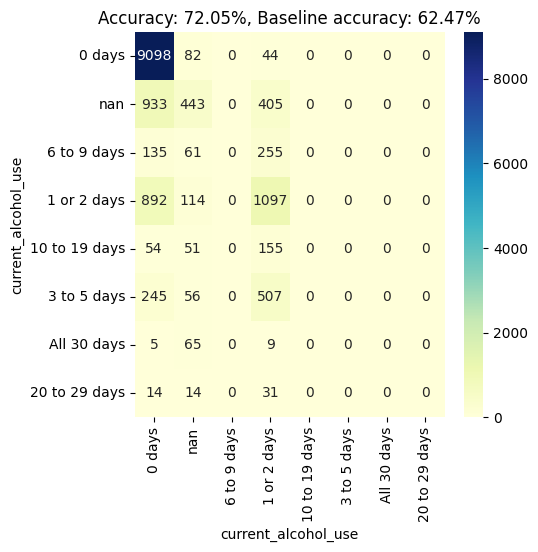

source_of_alcohol


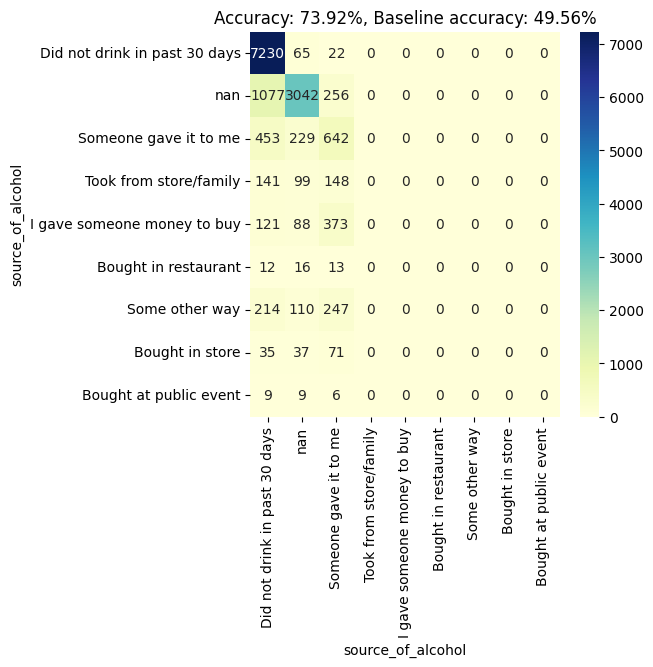

largest_number_of_drinks


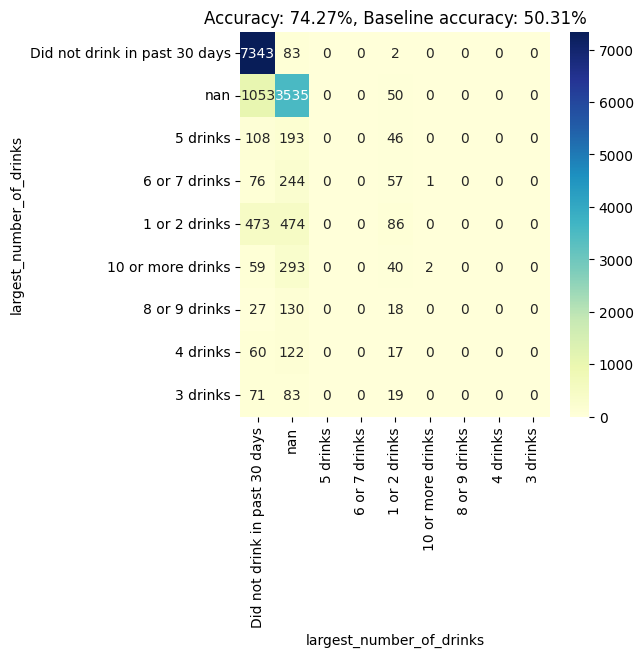

ever_marijuana_use


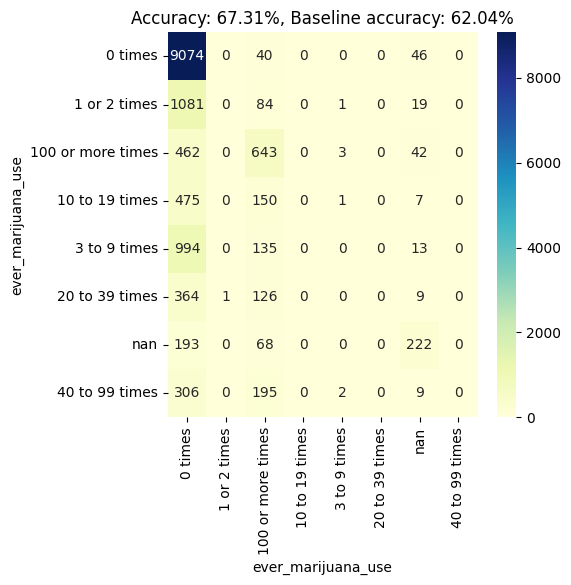

initiation_of_marijuana_use


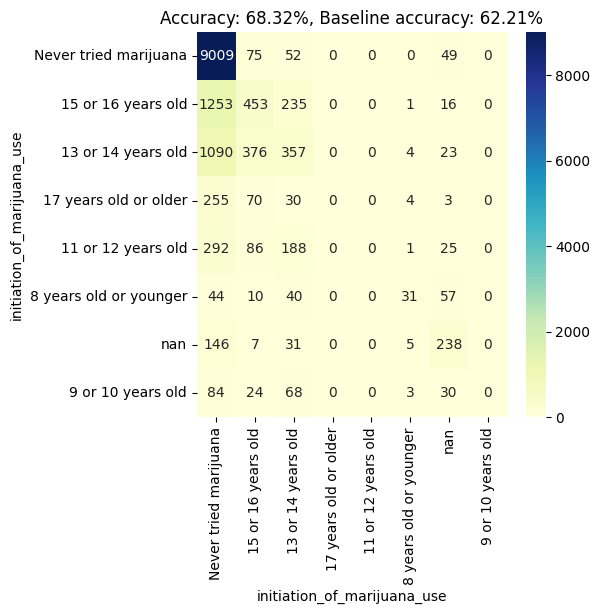

current_marijuana_use


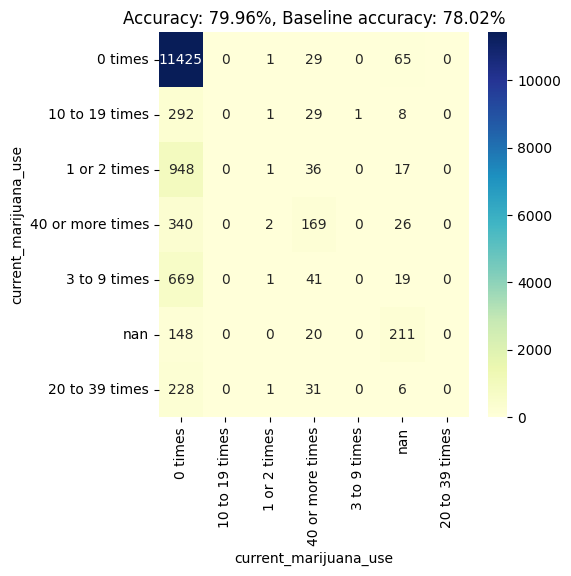

ever_cocaine_use


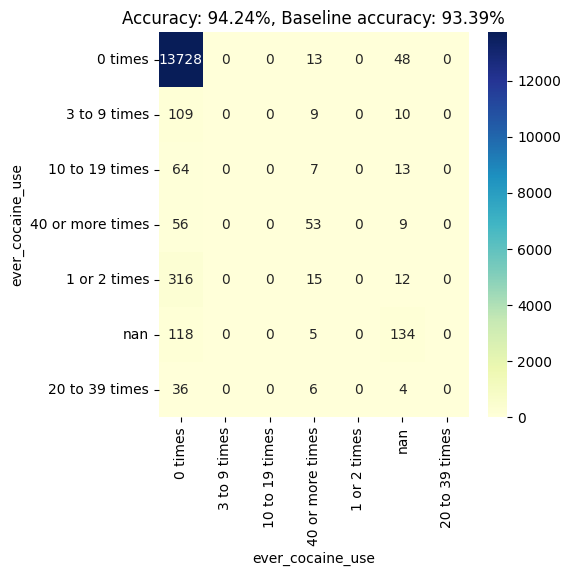

ever_inhalant_use


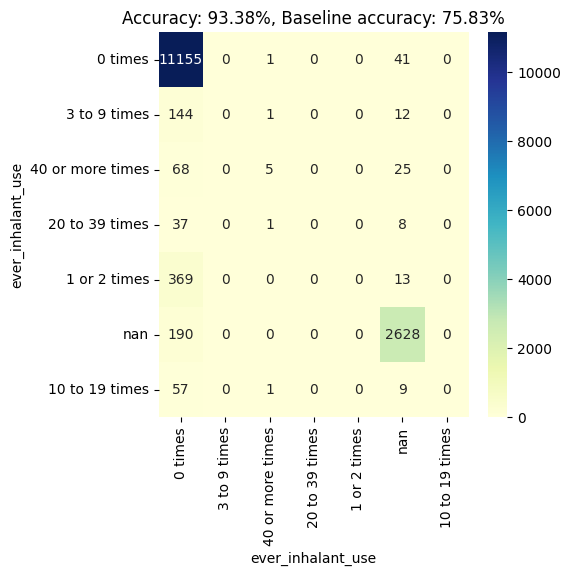

ever_heroin_use


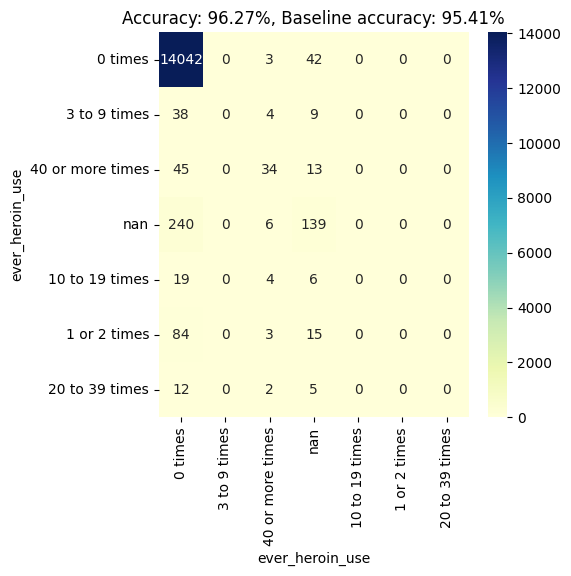

ever_methamphetamine_use


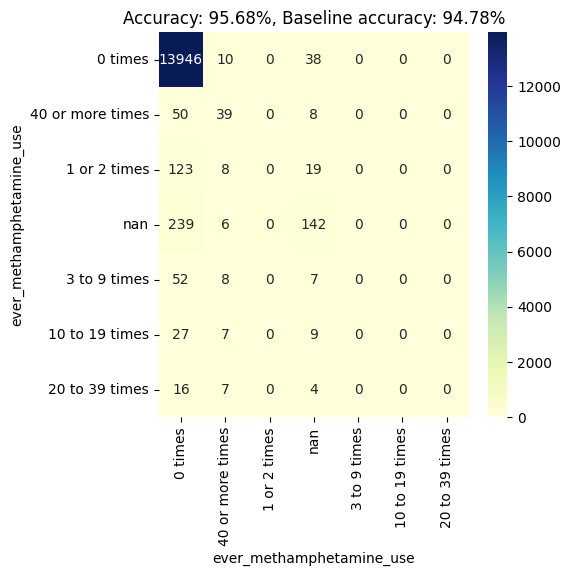

ever_ecstasy_use


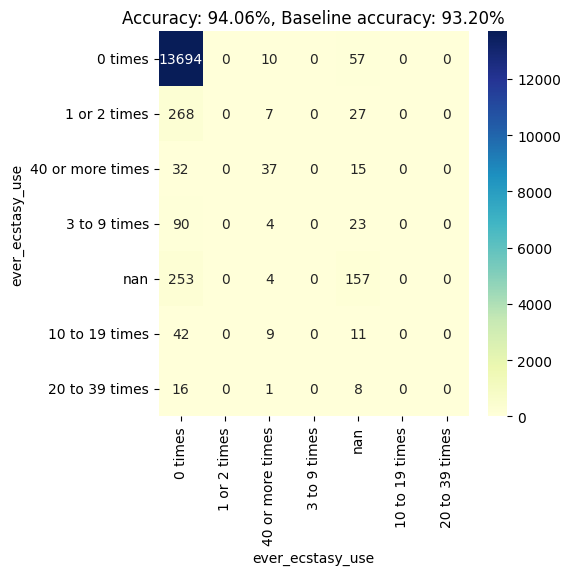

ever_synthetic_marijuana_use


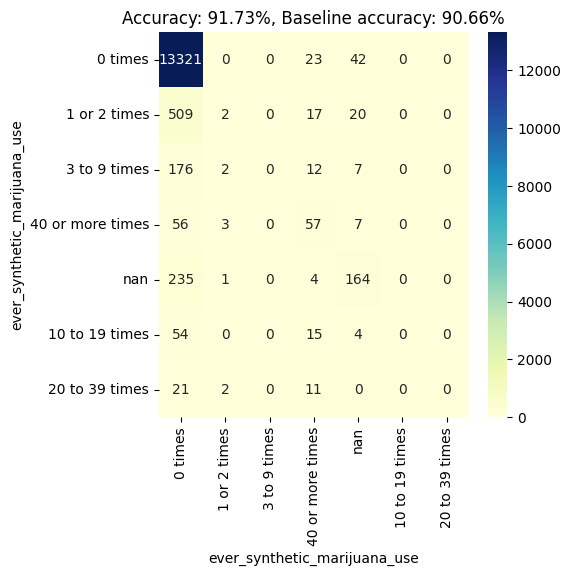

ever_steroid_use


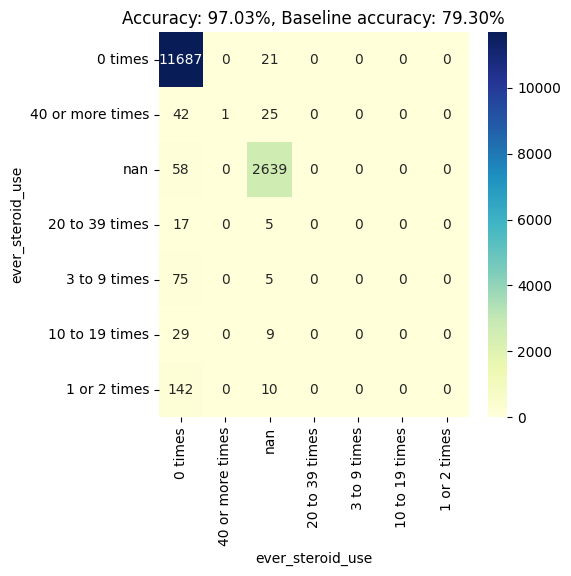

illegal_injected_drug_use


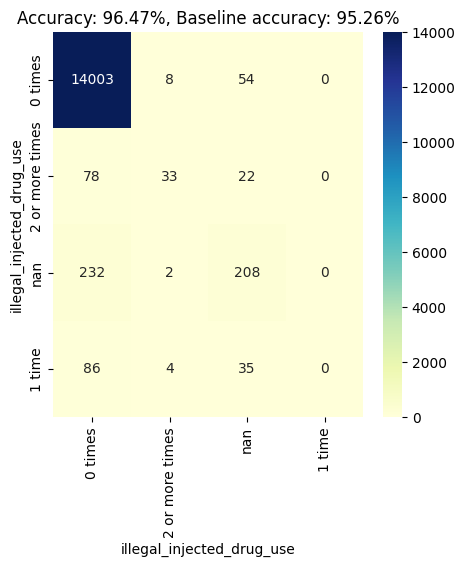

illegal_drugs_at_school


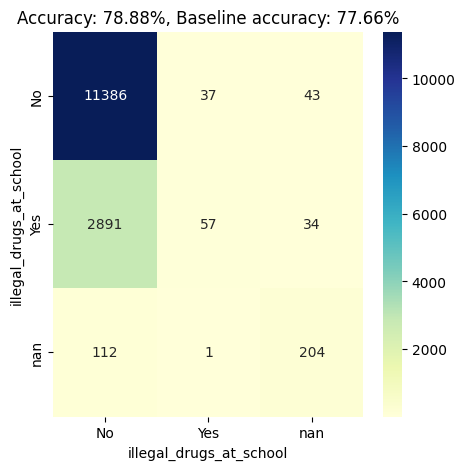

ever_sexual_intercourse


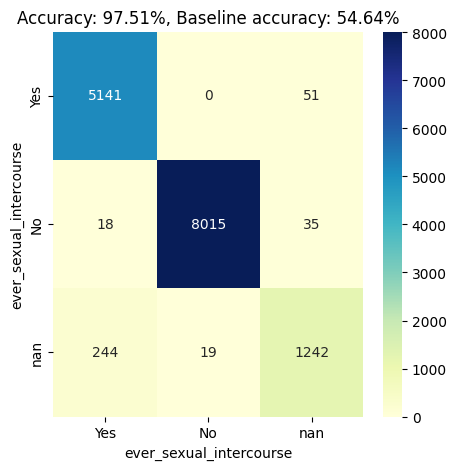

first_sex_intercourse


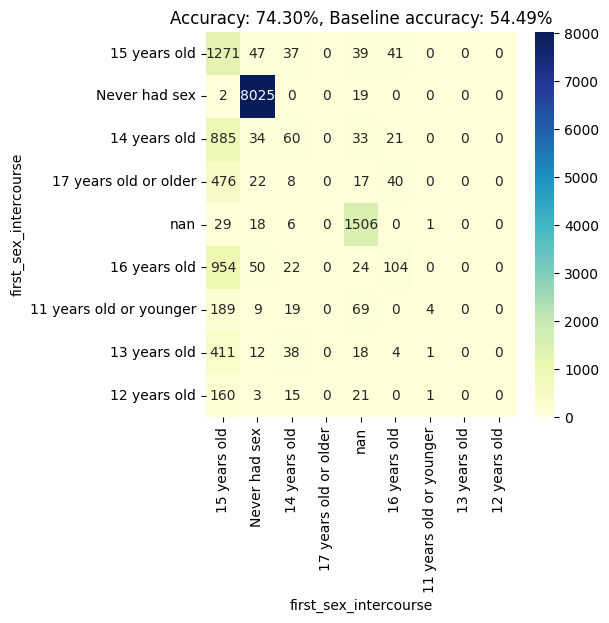

multiple_sex_partners


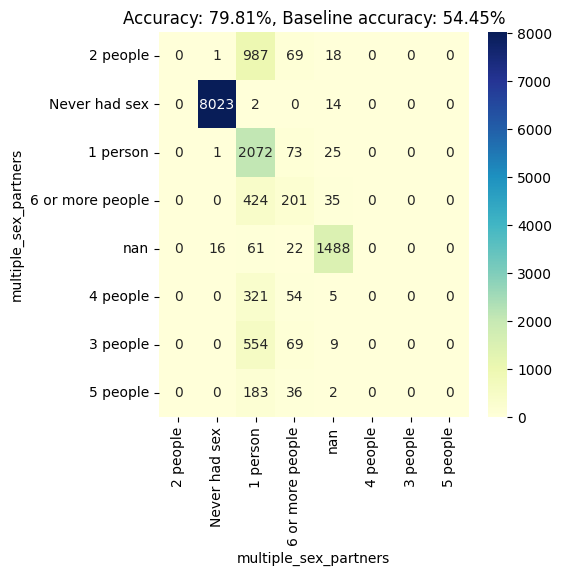

current_sexual_activity


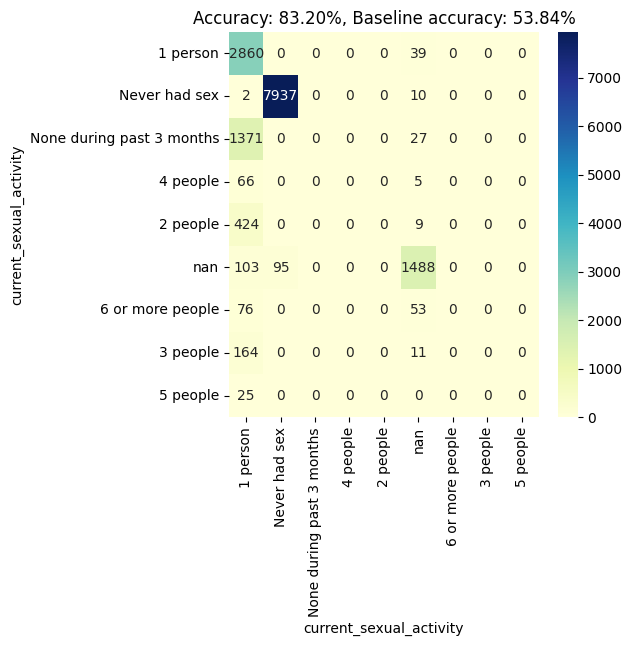

alcohol/drugs_at_sex


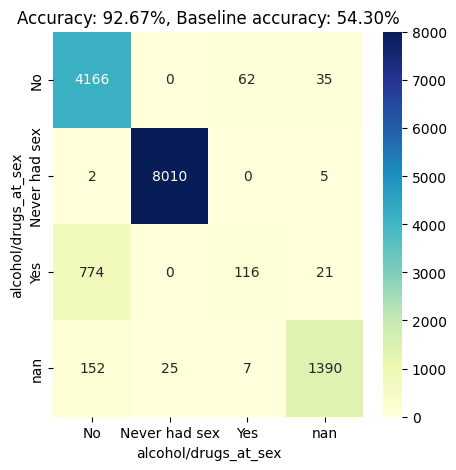

condom_use


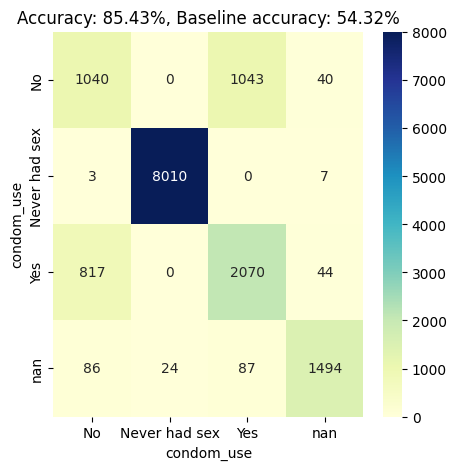

birth_control_pill_use


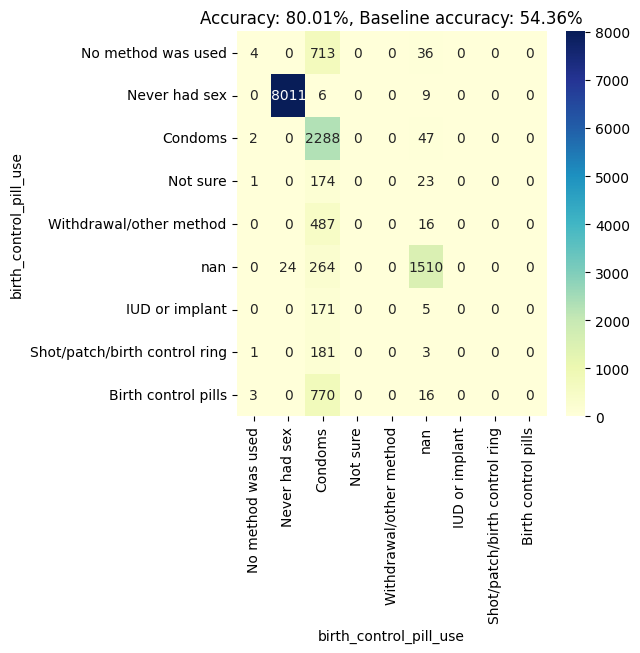

perception_of_weight


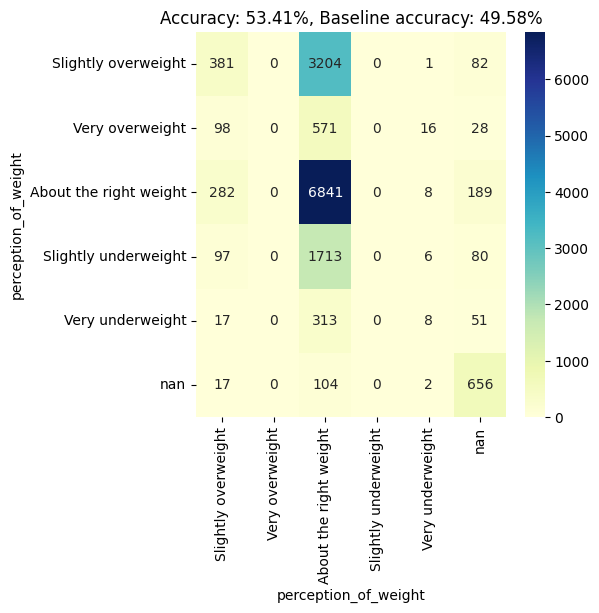

weight_loss


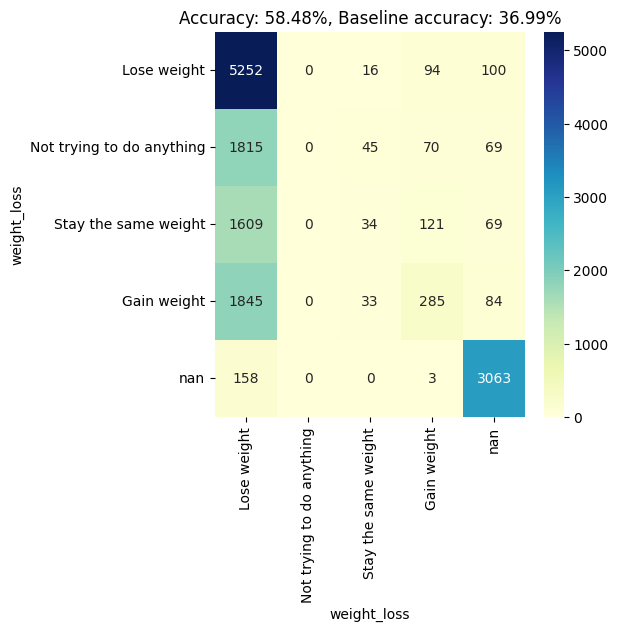

fruit_juice_drinking


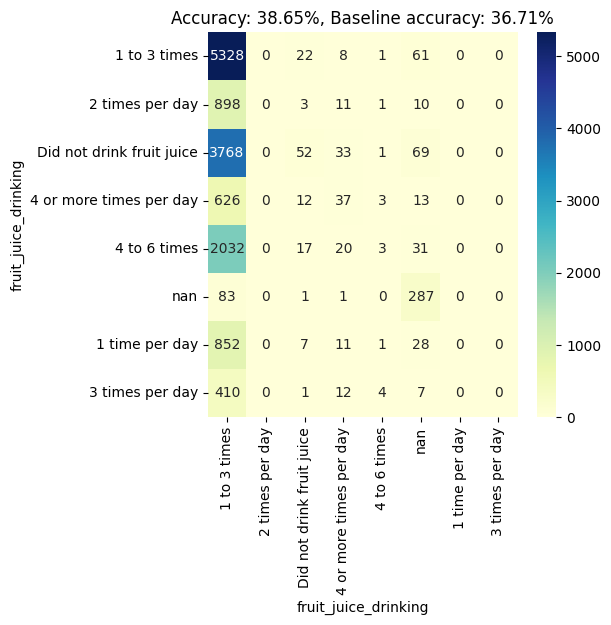

fruit_eating


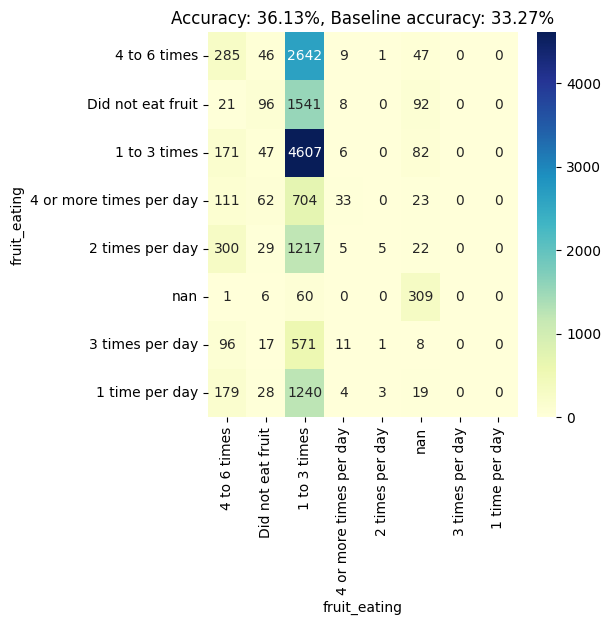

green _salad_eating


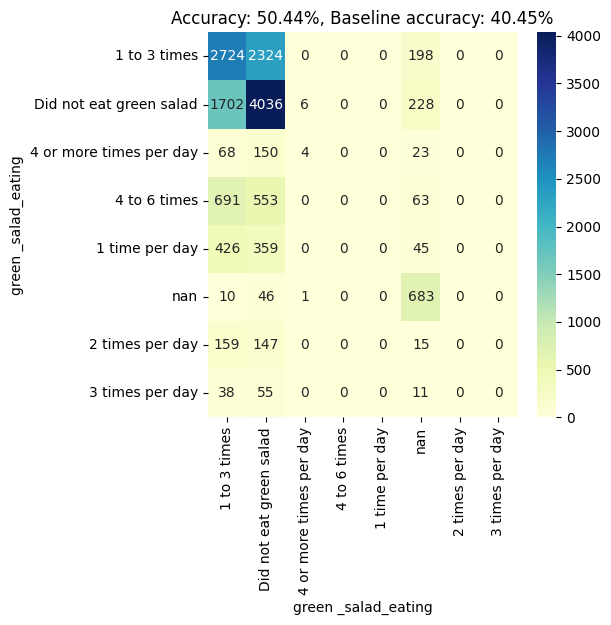

potato_eating


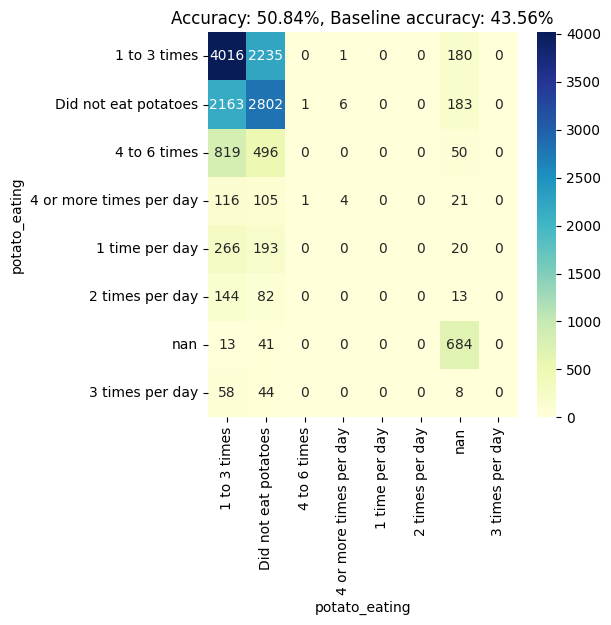

carrot_eating


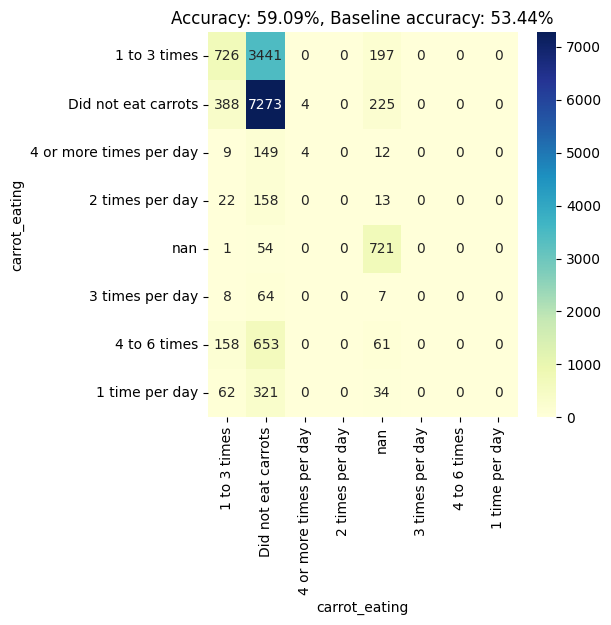

other_vegetable_eating


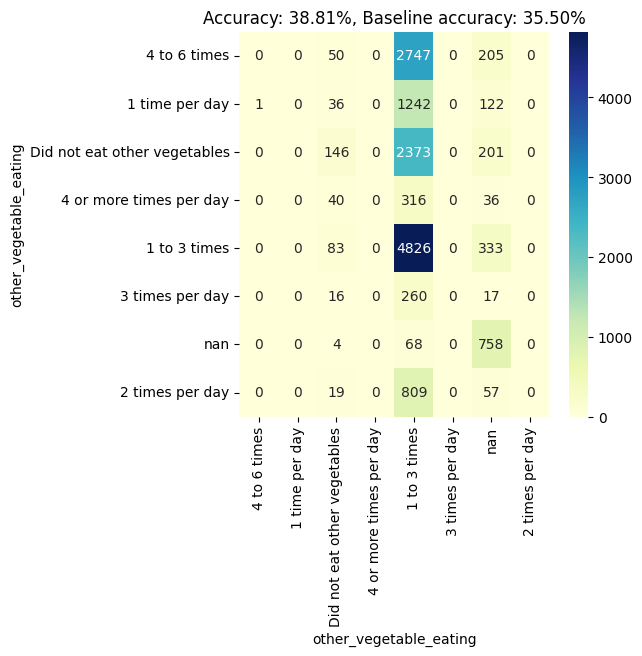

soda_drinking


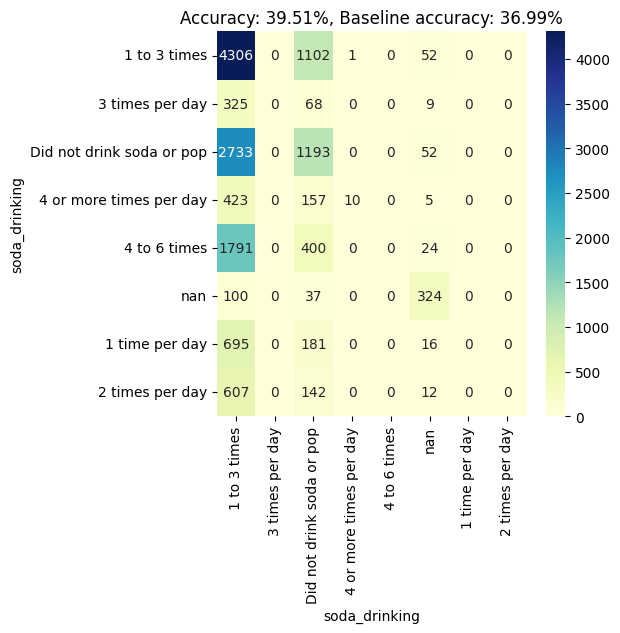

milk_drinking


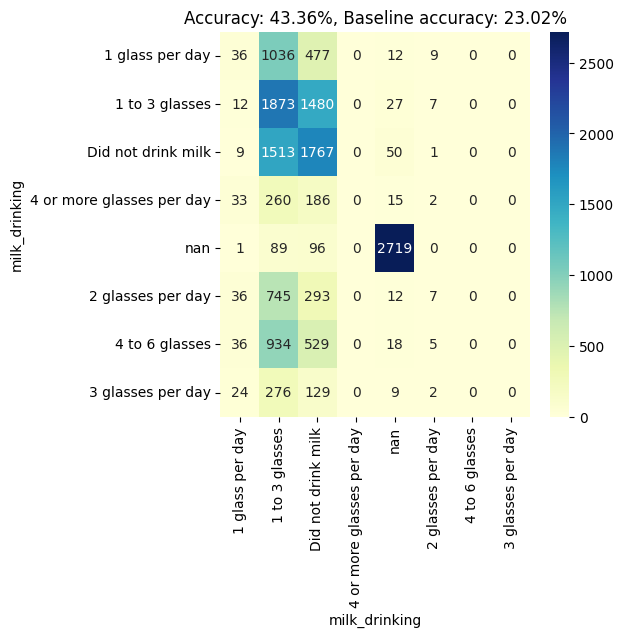

breakfast_eating


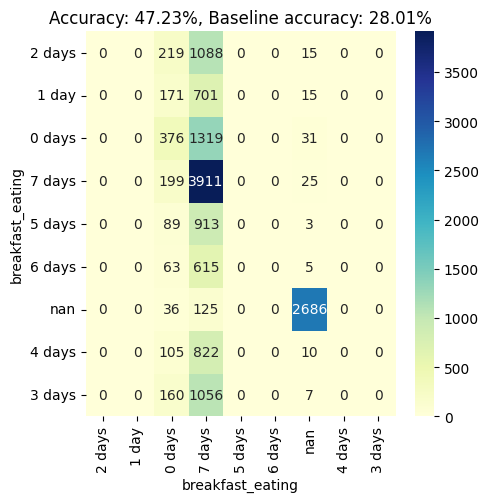

physical_activity


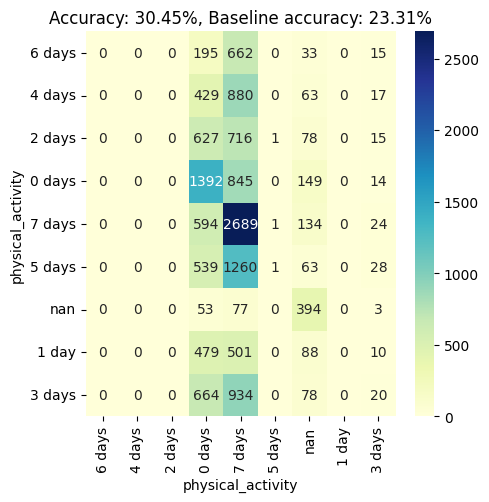

television_watching


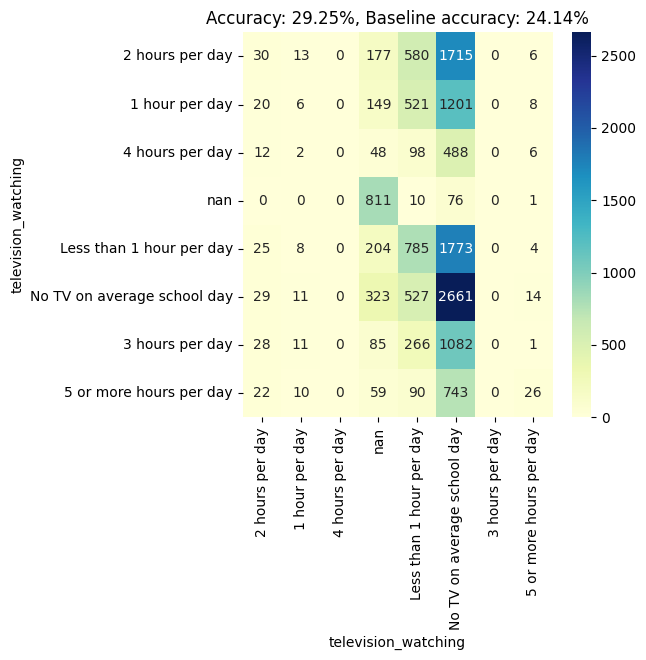

computer_not_school_work_use


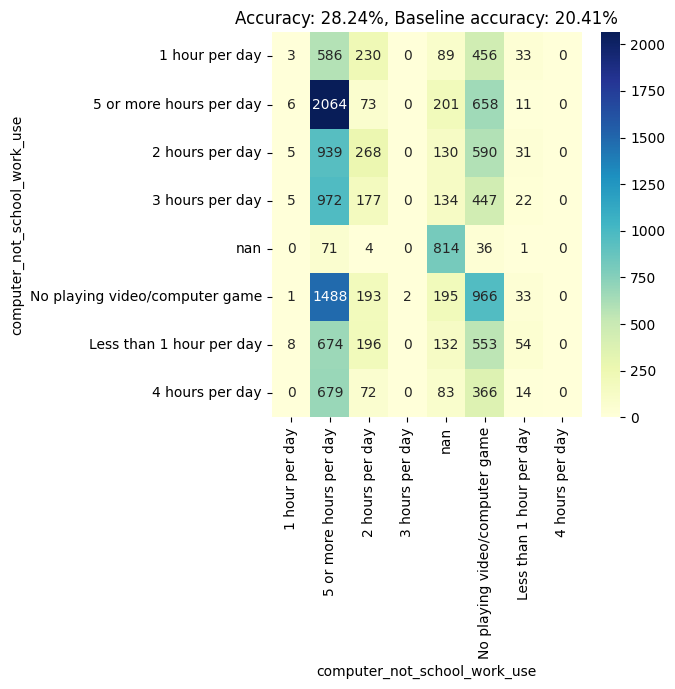

PE_attendance


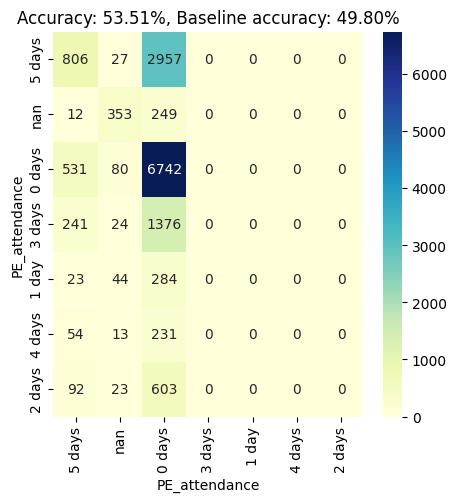

sports_team_participation


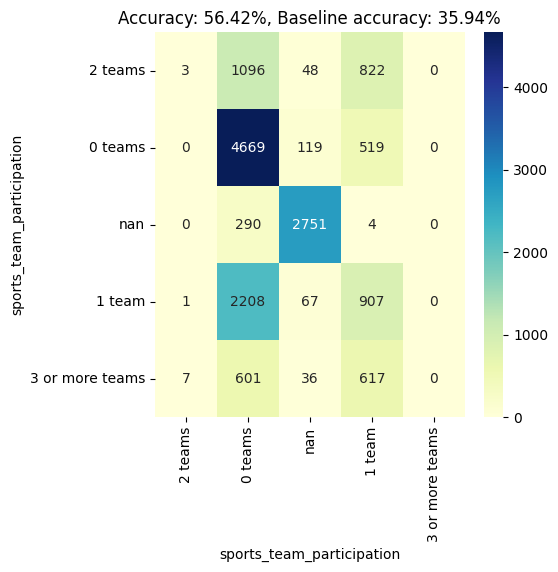

HIV_testing


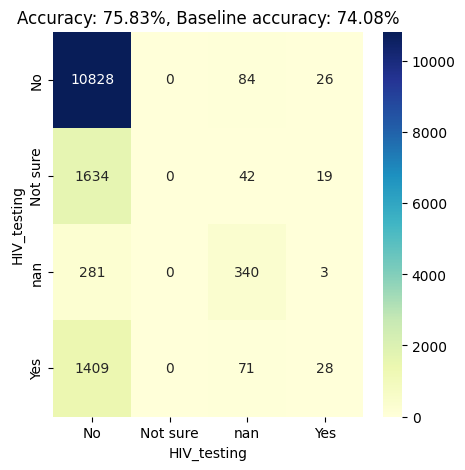

oral_health_care


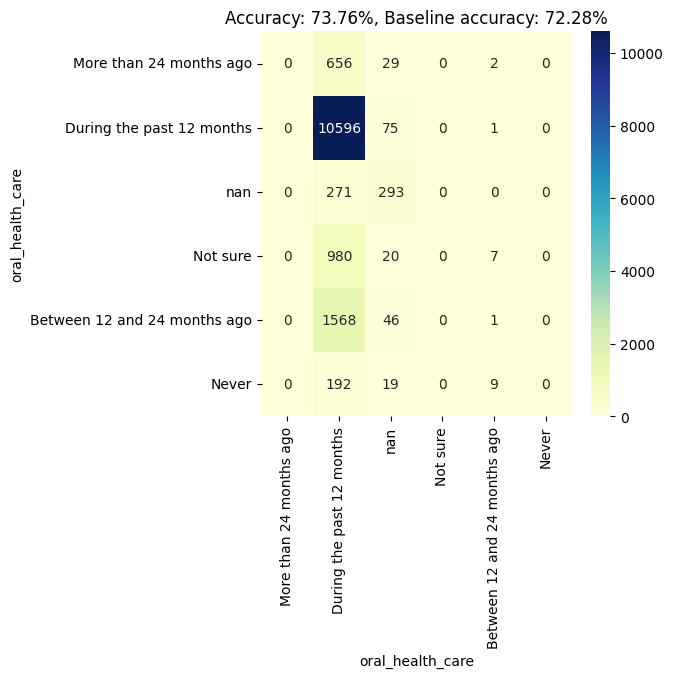

asthma


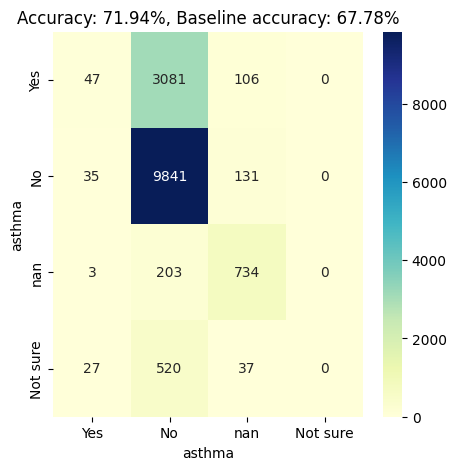

sleep_on_school_night


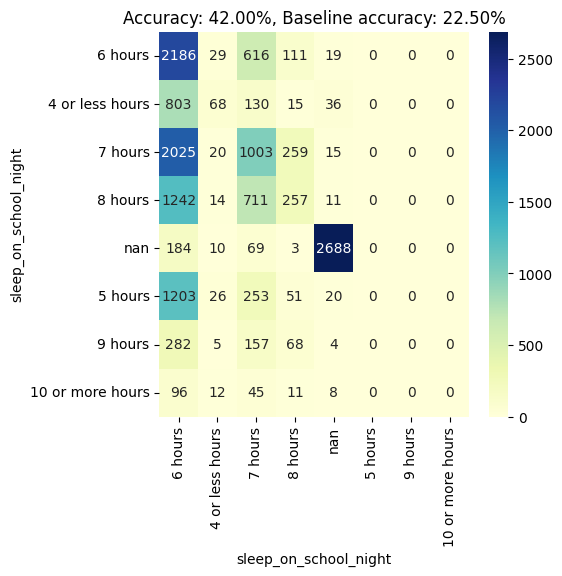

grades_in_school


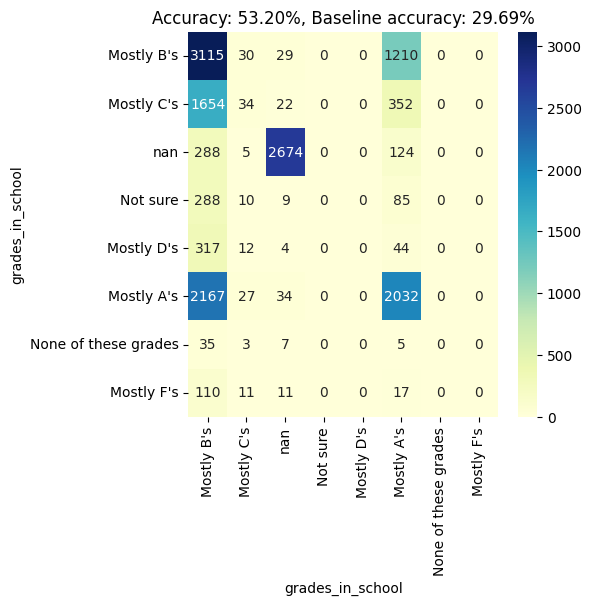

ever_used_LSD


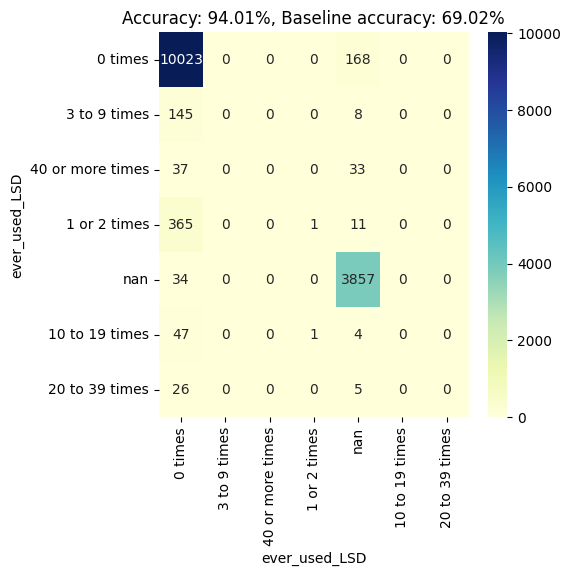

sports_drinks


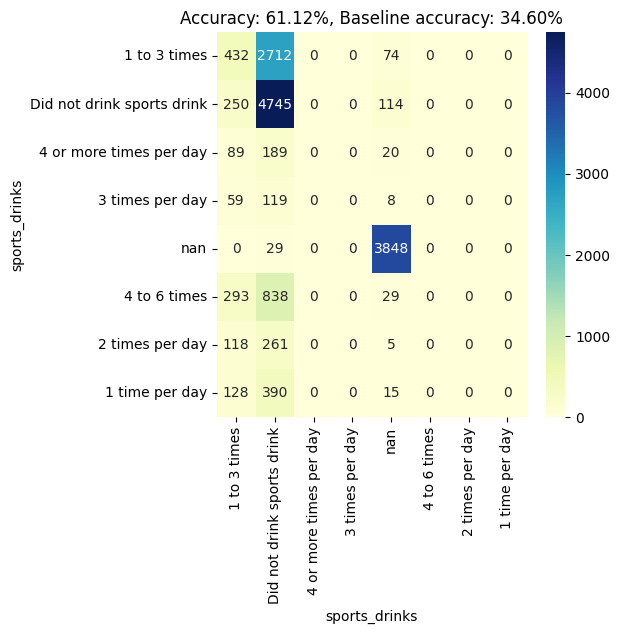

plain_water


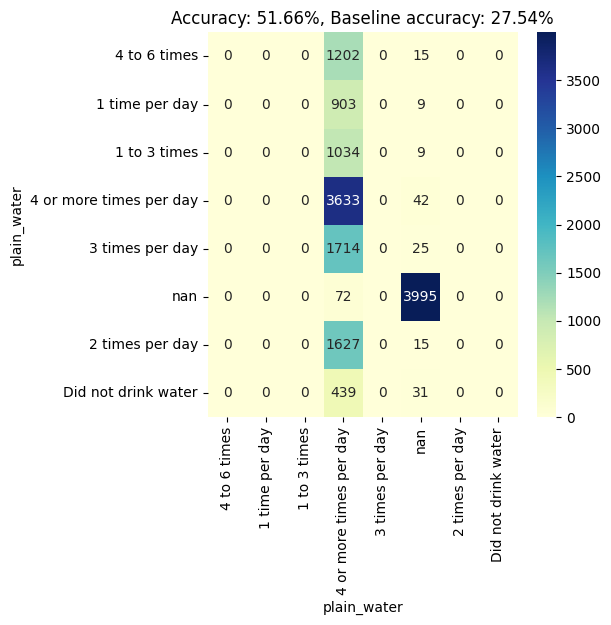

food_allergies


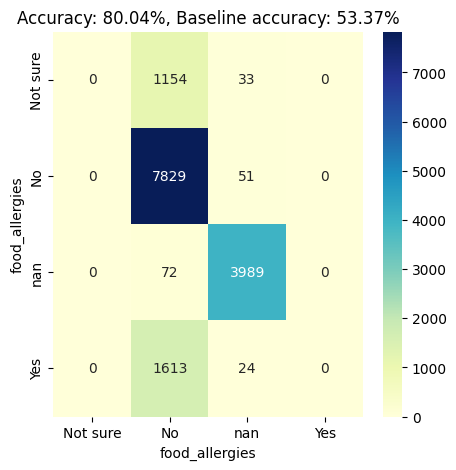

muscle_stregthening


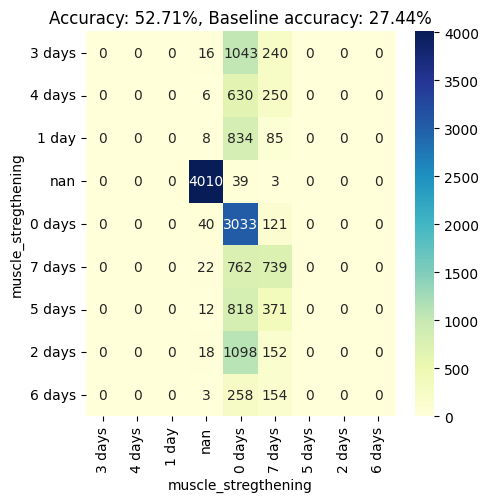

indoor_tanning


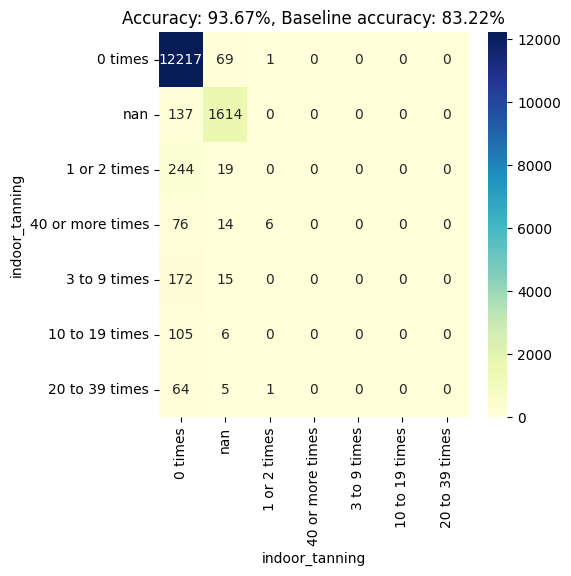

sunburn


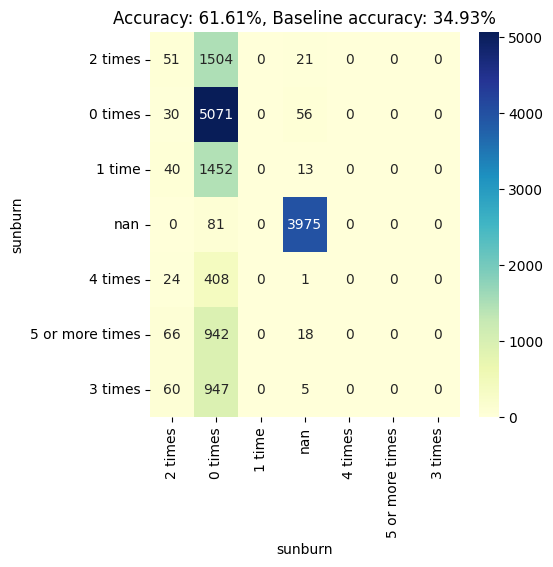

difficulty_concentrating


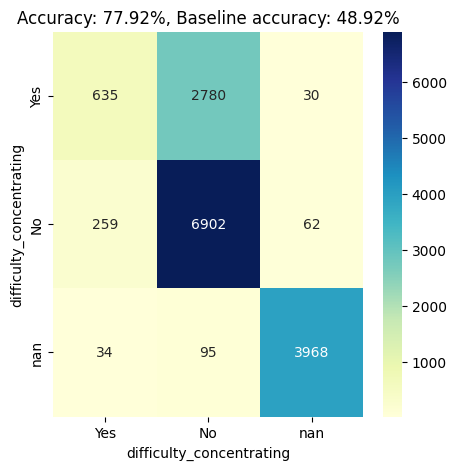

how_well_speak_English


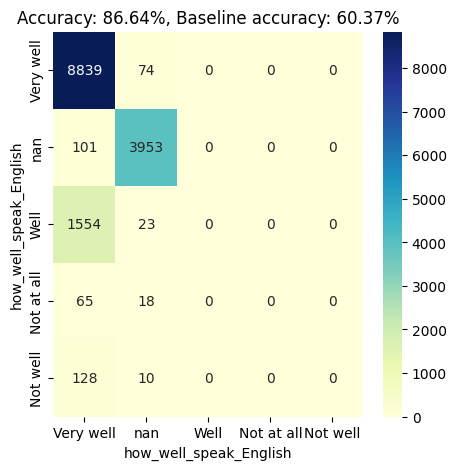

weight_cat


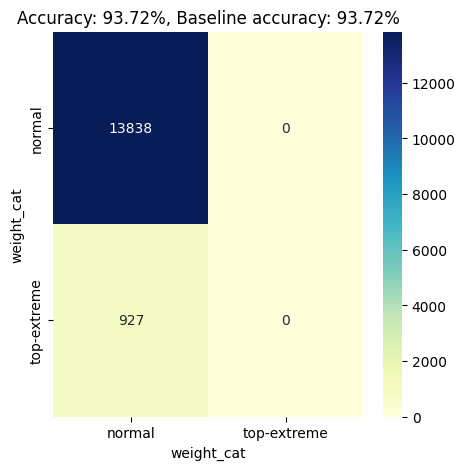

stheight_cat


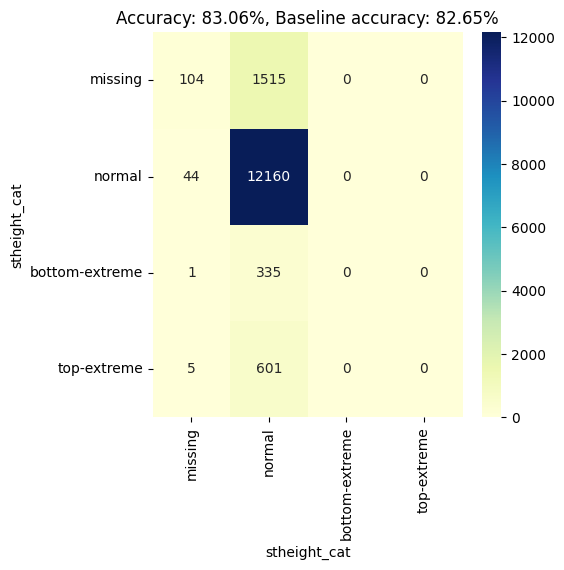

stweight_cat


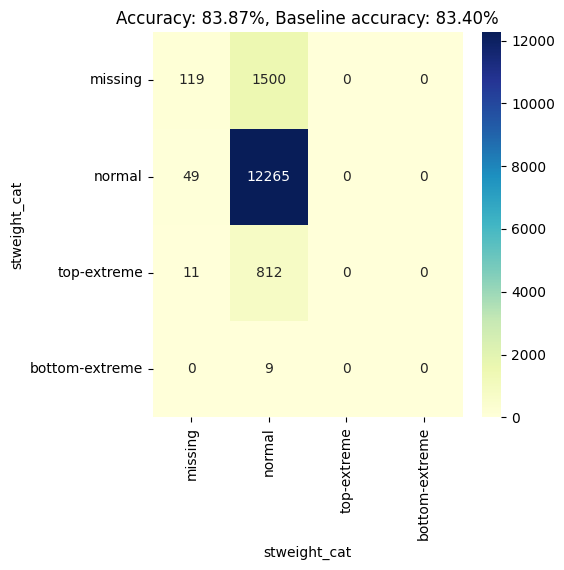

bmi_cat


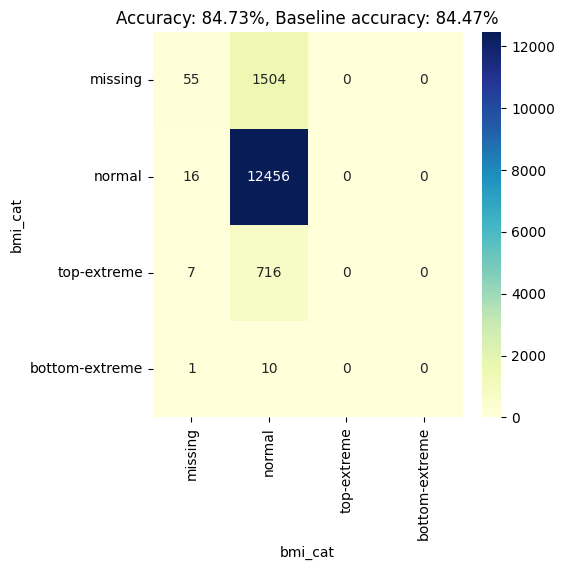

bmipct_cat


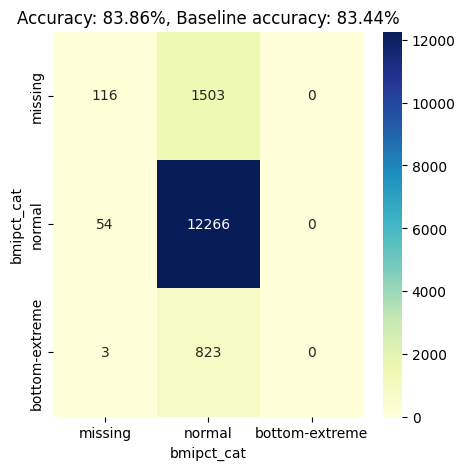

In [33]:
def create_scatterplot_for_categorical(original_df, predicted_df, categ_attr):
    all_categories = original_df[categ_attr].unique()
    confusion_matrix = pd.crosstab(original_df[categ_attr], predicted_df[categ_attr])
    confusion_matrix = confusion_matrix.reindex(index=all_categories, columns=all_categories, fill_value=0)

    diagonal_sum = np.trace(confusion_matrix.values)
    total_sum = np.sum(confusion_matrix.values)
    accuracy = diagonal_sum / total_sum * 100

    baseline_accuracy = original_df[categ_attr].value_counts().max() / total_sum * 100


    plt.figure(figsize=(5, 5))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap="YlGnBu")
    plt.title(f"Accuracy: {accuracy:.2f}%, Baseline accuracy: {baseline_accuracy:.2f}%")
    plt.show()
    return accuracy, baseline_accuracy

result = []
for v in variable_types.keys():
  if variable_types[v] == 'categorical':
    print(v)
    a,b = create_scatterplot_for_categorical(project_data, tabular_from_predicted, v)
    entry = { 'variable': v, 'accuracy': a, 'baseline_accuracy': b }
    result.append(entry)

result = pd.DataFrame(result)

In [34]:
def calculate_extended_metrics(original_df, predicted_df, categ_attr):
    all_categories = original_df[categ_attr].unique()
    confusion_matrix = pd.crosstab(original_df[categ_attr], predicted_df[categ_attr])
    confusion_matrix = confusion_matrix.reindex(index=all_categories, columns=all_categories, fill_value=0)

    diagonal_sum = np.trace(confusion_matrix.values)
    total_sum = np.sum(confusion_matrix.values)

    accuracy = diagonal_sum / total_sum * 100
    baseline_accuracy = original_df[categ_attr].value_counts().max() / total_sum * 100

    y_true = label_binarize(original_df[categ_attr], classes=all_categories)
    y_pred = label_binarize(predicted_df[categ_attr], classes=all_categories)
    ova_roc_auc = roc_auc_score(y_true, y_pred, multi_class='ovr', average='macro')

    return accuracy, baseline_accuracy, ova_roc_auc

# Example usage:
# accuracy, baseline_accuracy, ova_roc_auc = calculate_extended_metrics_without_prob(original_df, predicted_df, categ_attr)


result = []
for v in variable_types.keys():
  if variable_types[v] == 'categorical':
    print(v)
    if v.endswith("_cat"): continue
    a,b, c = calculate_extended_metrics(project_data, tabular_from_predicted, v)
    entry = { 'variable': v, 'accuracy': round(a,1), 'baseline_accuracy': round(b,1), 'ova_auc': c, 'lift': round(a/b,2) }
    result.append(entry)

df = pd.DataFrame(result)

df['lift'].mean()

age
sex
grade
Hispanic_or_Latino
race
obese
overweight
sexual_identity
sex/sexual_contacts
sexid
sexid2
sexpart
sexpart2
seat_belt_use
riding_with_a_drinking_driver
drinking_and_driving
texting_and_driving
weapon_carrying
weapon_carrying_at_school
safety_concerns_at_school
threatened_at_school
physical_fighting
physical_fighting_at_school
forced_sexual_intercourse
sexual_dating_violence
physical_dating_violence
bullying_at_school
electronic_bullying
sad_or_hopeless
considered_suicide
made_a_suicide_plan
attempted_suicide
injurious_suicide_attempt
ever_cigarette_use
current_cigarette_use
smoking_amounts_per_day
electronic_vapor_product_use
current_electronic_vapor_product_use
current_cigar_use
ever_alcohol_use
initiation_of_alcohol_use
current_alcohol_use
source_of_alcohol
largest_number_of_drinks
ever_marijuana_use
initiation_of_marijuana_use
current_marijuana_use
ever_cocaine_use
ever_inhalant_use
ever_heroin_use
ever_methamphetamine_use
ever_ecstasy_use
ever_synthetic_marijuana_use
e

1.293763440860215

In [35]:
df.sort_values(by='ova_auc', ascending=False).head(25)

variable  accuracy  baseline_accuracy   ova_auc  lift
56       ever_sexual_intercourse      97.5               54.6  0.962028  1.78
61                    condom_use      85.4               54.3  0.862587  1.57
60          alcohol/drugs_at_sex      92.7               54.3  0.860642  1.71
33            ever_cigarette_use      82.4               58.2  0.819799  1.41
12                      sexpart2      86.0               36.4  0.815382  2.37
8            sex/sexual_contacts      81.6               36.6  0.797661  2.23
91      difficulty_concentrating      77.9               48.9  0.782115  1.59
11                       sexpart      86.0               36.4  0.752300  2.37
87                food_allergies      80.0               53.4  0.694170  1.50
58         multiple_sex_partners      79.8               54.4  0.684985  1.47
36  electronic_vapor_product_use      74.9               56.9  0.681751  1.32
92        how_well_speak_English      86.6               60.4  0.663932  1.44
57         first_sex_intercourse      74.3               54.5  0.650651  1.36
59       current_sexual_activity      83.2               53.8  0.647437  1.55
32     injurious_suicide_attempt      83.7               66.2  0.645297  1.26
19     safety_concerns_at_school      93.5               76.7  0.643758  1.22
62        birth_control_pill_use      80.0               54.4  0.643540  1.47
78     sports_team_participation      56.4               35.9  0.643310  1.57
54     illegal_injected_drug_use      96.5               95.3  0.642485  1.01
64                   weight_loss      58.5               37.0  0.641546  1.58
53              ever_steroid_use      97.0               79.3  0.633318  1.22
84                 ever_used_LSD      94.0               69.0  0.629523  1.36
48             ever_inhalant_use      93.4               75.8  0.623436  1.23
55       illegal_drugs_at_school      78.9               77.7  0.622807  1.02
17               weapon_carrying      85.2               67.9  0.621391  1.25

In [36]:
df.sort_values(by=['ova_auc','baseline_accuracy'], ascending=True).head(25)

variable  accuracy  baseline_accuracy  \
27                   electronic_bullying      84.5               84.5   
26                    bullying_at_school      80.9               80.9   
18             weapon_carrying_at_school      94.2               94.2   
23             forced_sexual_intercourse      90.4               90.3   
14         riding_with_a_drinking_driver      83.4               83.2   
20                  threatened_at_school      93.4               93.2   
37  current_electronic_vapor_product_use      76.3               75.7   
30                   made_a_suicide_plan      85.0               84.7   
34                 current_cigarette_use      89.7               89.3   
6                             overweight      75.0               74.5   
5                                  obese      76.4               75.9   
29                    considered_suicide      81.6               81.2   
22           physical_fighting_at_school      89.4               89.2   
38                     current_cigar_use      90.2               90.0   
0                                    age      31.7               25.0   
4                                   race      48.1               42.4   
16                   texting_and_driving      52.6               38.1   
80                      oral_health_care      73.8               72.3   
65                  fruit_juice_drinking      38.7               36.7   
71                         soda_drinking      39.5               37.0   
2                                  grade      35.7               26.6   
77                         PE_attendance      53.5               49.8   
70                other_vegetable_eating      38.8               35.5   
15                  drinking_and_driving      66.8               51.5   
66                          fruit_eating      36.1               33.3   

     ova_auc  lift  
27  0.500000  1.00  
26  0.500552  1.00  
18  0.506022  1.00  
23  0.507029  1.00  
14  0.511048  1.00  
20  0.512182  1.00  
37  0.512338  1.01  
30  0.515433  1.00  
34  0.517031  1.00  
6   0.519073  1.01  
5   0.520439  1.01  
29  0.520456  1.01  
22  0.521184  1.00  
38  0.524061  1.00  
0   0.527315  1.27  
4   0.538168  1.13  
16  0.543365  1.38  
80  0.550194  1.02  
65  0.554149  1.05  
71  0.555329  1.07  
2   0.558310  1.34  
77  0.559551  1.07  
70  0.561036  1.09  
15  0.561998  1.30  
66  0.563777  1.09

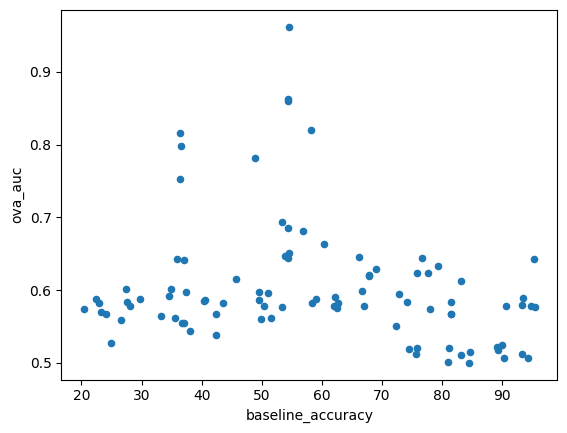

In [37]:
df.plot(x='baseline_accuracy', y='ova_auc', kind='scatter')
plt.show()